### Import Libraries
---

In [104]:
# used in the scraping portion of the project (some of these were used at first, and then failed: selenium was used as primary scraping tool)
from scrapethat import *
import requests
from bs4 import BeautifulSoup
import pandas as pd
import json
import re
import json
from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from urllib.parse import quote_plus
from selenium.common.exceptions import TimeoutException, NoSuchElementException
from datetime import datetime, timedelta
import os
import time

# used in the visualization portion of the project
import warnings
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.image as mpimg
import seaborn as sns

# Importing the following for the data analysis portion of the project
import sys
import numpy as np
from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
from IPython.core.display import HTML
from stargazer.stargazer import Stargazer
import statsmodels.nonparametric.kernel_regression as loess

from mizani.transforms import log_trans
from mizani.formatters import percent_format
from mizani.formatters import log_format


# Scraping Process

## Scrape Hostel Data

This scraping function allows us to scrape data from Hostel World on hostel prices for given time periods in selected cities. 

A list of cities to scrape was created so that it could be fed through the function. Data was collected for every day in January, April, July, and October of 2024 for every city and every hostel in each city. 

The different data that was collected from each hostel is as follows: 
- Hostel_Name
- Rating
- Rating_Ct
- Private_Rm_Price
- Dorm_Price
- Rating_Descript
- Accomm_Type
- Distance
- City
- Country
- Date
---

### Function that scrapes price data over the course of a year on every hostel in a given list of city names
---

In [104]:
def scrape_hostel_data(driver, city, region, country, city_id, from_date, to_date, guests, max_pages):
    """
    This function allows us to scrape detailed listing data for a given date. 
    The primary focus is to scrape the price data here, and compile it into a dataframe. 
    This function takes city, region, country, city_id, from_date, to_date, and guests as input
    and connects it to a link through an F-String. 
    
    A list with city, region, country, and city_id data was created so that this list can be fed through
    the function, and specified dates can be looped through as well. 
    
    Note: the webdriver is not included in this function for the purpose of saving time. When included, 
    it would open and close the webdriver for every item in the list. This method below allowed for the 
    driver to be open the entire time. 
    """
    # generate the hostelworld.com link with specified parameters
    base_url = f"https://www.hostelworld.com/pwa/wds/s?q={city}%2C+{region}%2C+{country}&country={city}&city={city}&type=city&id={city_id}&from={from_date}&to={to_date}&guests={guests}&page=1"

    # initialize webdriver
    driver.get(base_url)


    try:
        # lists for the different variables (not in order of collection)
        hostel_names = []
        hostel_links = set()
        hostel_ratings = []
        hostel_rating_counts = []
        hostel_private_prices = []
        hostel_dorm_prices = []
        hostel_rating_descriptions = []
        hostel_accom_types = []
        hostel_distances = []

        # everything we need to collect is in the class property-info-container
        # https://stackoverflow.com/questions/63170066/selenium-how-does-webdriverwait-presence-of-all-elements-located-actually-wor
        property_containers = WebDriverWait(driver, 10).until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, '.property-info-container')))
        
        # this for loop allows us to go through the containers, but skip the first three because there is a duplicated containers on the website at the top
        # ....that are called featured. could not figure out how to skip containers with a certain class, so decided to start at the 3 index
        #https://www.selenium.dev/documentation/webdriver/elements/finders/
        for container in property_containers[3:]: 
            # Names, Ratings, Rating Counts, Prices
            name_elements = container.find_elements(By.CSS_SELECTOR, '.property-name')
            rating_elements = container.find_elements(By.CSS_SELECTOR, '.number')
            rating_count_elements = container.find_elements(By.CSS_SELECTOR, '.left-margin')
            accommodation_element = container.find_element(By.CSS_SELECTOR, '.property-accommodations')
            
            # handling empty values
            hostel_names.append(name_elements[0].text if name_elements else 'Not Available')
            hostel_ratings.append(rating_elements[0].text if rating_elements else '0')
            hostel_rating_counts.append(rating_count_elements[0].text if rating_count_elements else '0')
            
            # Prices
            try:
                private_price_element = accommodation_element.find_element(By.XPATH, ".//div[contains(text(),'Privates From')]/following-sibling::div/strong[@class='current']")
                # this xpath was developed with the assistance of chatgpt, as there were many issues that I ran into when scraping private room data
                hostel_private_prices.append(private_price_element.text)
            except NoSuchElementException:
                hostel_private_prices.append("Not Available")

            try:
                dorm_price_element = accommodation_element.find_element(By.XPATH, ".//div[contains(text(),'Dorms From')]/following-sibling::div/strong[@class='current']")
                # this xpath was developed with the assistance of chatgpt, as there were many issues that I ran into when scraping private room data
                hostel_dorm_prices.append(dorm_price_element.text)
            except NoSuchElementException:
                hostel_dorm_prices.append("Not Available")

            # Rating Description
            keyword_elements = container.find_elements(By.CSS_SELECTOR, '.keyword')
            #handling null rating descriptions
            hostel_rating_descriptions.append(keyword_elements[0].text if keyword_elements else 'NULL')

            # Accommodation Type
            accom_type_elements = container.find_elements(By.CSS_SELECTOR, '.distance-property-type')
            # handling null accommodation types
            hostel_accom_types.append(accom_type_elements[0].text if accom_type_elements else 'NULL')

            # Distance
            distance_elements = container.find_elements(By.CSS_SELECTOR, '.distance-description')
            if distance_elements:
                pattern = r"\d+\.\d+|\d+" #this pattern was developed by chatgpt, as it is a complex regex expression
                distance = 'NULL'
                for distance_element in distance_elements:
                    match = re.search(pattern, distance_element.text)
                    if match:
                        distance = match.group()
                        break
                hostel_distances.append(distance)
            else:
                hostel_distances.append('NULL')
            # was able to successfully scrape distance information with this code, was receiving too many errors otherwise

        # Scrape Hostel Links
        for page in range(max_pages):
            try:
                listings = WebDriverWait(driver, 20).until(EC.presence_of_all_elements_located((By.CLASS_NAME, "nuxt-link")))
                page_links = [listing.get_attribute('href') for listing in listings]
                hostel_links.update(page_links)
            except Exception as e:
                print(f"An error occurred on page {page}: {e}")

        # made the links go back to list
        hostel_links = list(hostel_links)

    except TimeoutException:
        print("An error occurred during scraping.")
        return pd.DataFrame()


    # the following was developed with the assistance of chatgpt because I was receiving a lot of errors with the lengths of data columns
    # came to the conclusion that there is an 
    max_length = max(len(hostel_names), len(hostel_ratings), len(hostel_rating_counts),
                     len(hostel_private_prices), len(hostel_dorm_prices), 
                     len(hostel_rating_descriptions), len(hostel_accom_types), len(hostel_distances),
                     len(hostel_links)) 

    def equalize_list_length(lst, max_length, default_value):
        return lst + [default_value] * (max_length - len(lst))

    hostel_names = equalize_list_length(hostel_names, max_length, 'Not Available')
    hostel_links = equalize_list_length(hostel_links, max_length, 'Not Available')
    hostel_ratings = equalize_list_length(hostel_ratings, max_length, '0')
    hostel_rating_counts = equalize_list_length(hostel_rating_counts, max_length, '0')
    hostel_private_prices = equalize_list_length(hostel_private_prices, max_length, 'Not Available')
    hostel_dorm_prices = equalize_list_length(hostel_dorm_prices, max_length, 'Not Available')
    hostel_rating_descriptions = equalize_list_length(hostel_rating_descriptions, max_length, 'Not Available')
    hostel_accom_types = equalize_list_length(hostel_accom_types, max_length, 'Not Available')
    hostel_distances = equalize_list_length(hostel_distances, max_length, '0')
    
    
    
    # Basic dataframe created
    df = pd.DataFrame({
        'Hostel_Name': hostel_names,
        'Hostel_Link': hostel_links,
        'Rating': hostel_ratings,
        'Rating_Ct': hostel_rating_counts,
        'Private_Rm_Price': hostel_private_prices,
        'Dorm_Price': hostel_dorm_prices,
        'Rating_Descript': hostel_rating_descriptions,
        'Accomm_Type': hostel_accom_types,
        'Distance': hostel_distances
    })

    
    # added city and country columns
    df['City'] = city
    df['Country'] = country
    
    return df


### List of cities, regions, countries, and city IDs for link creation
---

In [3]:
# list was input manually for the purpose of simplicity
city_country_id_list = [
    ('Berlin', 'Germany', 'Germany', 26), #works
    ('Rome', 'Lazio', 'Italy', 36), #works
    ('Madrid', 'Spain', 'Spain', 117), #works
    ('London', 'England', 'England', 3), #works
    ('Amsterdam', 'Netherlands', 'Netherlands', 15), #works
    ('Prague','Czech+Republic','Czech+Republic', 19), #works
    ('Vienna', 'Austria', 'Austria', 38), #works
    ('Budapest', 'Hungary', 'Hungary', 50), #works
    ('Athens', 'Greece', 'Greece', 588), #works
    ('Istanbul', 'Turkey', 'Turkey', 51), #works
    ('Dublin', 'Ireland', 'Ireland', 5), #works
    ('Brussels', 'Belgium', 'Belgium', 35), #works
    ('Lisbon', 'Portugal', 'Portugal', 725), #works
    ('Warsaw', 'Poland', 'Poland', 884), #works
    ('Oslo', 'Norway', 'Norway', 138), #works
    ('Stockholm', 'Sweden', 'Sweden', 143), #works
    ('Helsinki', 'Finland', 'Finland', 612), #works
    ('Copenhagen', 'Denmark', 'Denmark', 48), #works
    ('Riga', 'Latvia', 'Latvia', 224), #works
    ('Tallinn', 'Estonia', 'Estonia', 451), #works
    ('Vilnius', 'Lithuania', 'Lithuania', 583), #works
    ('Tokyo', 'Japan', 'Japan', 452), #works
    ('Seoul', 'South+Korea', 'South+Korea', 1103), #works
    ('Beijing', 'China', 'China', 811), #works
    ('Shanghai', 'China', 'China', 1065), #works
    ('Bangkok', 'Thailand', 'Thailand', 149), #works
    ('New+Delhi', 'India', 'India', 313), #works
    ('Mumbai', 'India', 'India', 346), #works
    ('Kuala+Lumpur', 'Malaysia', 'Malaysia', 183), #works
    ('Singapore', 'Singapore', 'Singapore', 93), #works
    ('Dubai', 'United+Arab+Emirates', 'United+Arab+Emirates', 1177) #works
]


### scrape_hostel_data function test 1:
Testing a manually entered date for each city in the list of cities

---

In [ ]:
"""
This code executes the scrape_hostel_data function, and is purely for a test. It takes prices for a
specified time frame and is the prequel test to the code that runs the list through the scrape_hostel_data
function. 
"""
# initalizing the webdriver
options = webdriver.ChromeOptions()
driver = webdriver.Chrome(options=options)
driver.maximize_window()

# put each city into a dictionary
city_dataframes = {}

# scrape data for each city
try:
    for city, region, country, city_id in city_country_id_list:
        df_city = scrape_hostel_data(driver, city, region, country, city_id, "2024-01-01", "2024-01-02", 1, max_pages=5)
        city_dataframes[city] = df_city
finally:
    driver.quit()

# eample: city_dataframes['Vienna']


### scrape_hostel_data function test 2
Testing the date for loop for the first city in the list to make sure it collects all requested date data

--- 

In [ ]:
"""
This was another test code to create a dataframe for the first city in the list of cities.
The idea with this was to make sure it had the capabililty of running for the first country. 
This ran successfully and collected prices for each day in January, April, July, and October.
It concated each day into a dataframe. 
"""
# Initialize WebDriver
options = webdriver.ChromeOptions()
driver = webdriver.Chrome(options=options)
driver.maximize_window()

# select specific months for scraping
months = [1, 4, 7, 10]  # January, April, July, October
# chose these months to get data across different seasons

# all_data will hold the data for now
all_data = pd.DataFrame()

try:
    # testing the first entry from the list of countries
    city, region, country, city_id = city_country_id_list[0]

    # feeding the selected months through a for loop so that each of my selected months are used
    for month in months:
        month_start = datetime(2024, month, 1)
        month_end = datetime(2024, month + 1, 1) if month < 12 else datetime(2025, 1, 1)

        
        # used chatgpt to help me itereate into the link to create a loop for time series data collection
        while month_start < month_end:
            from_date = month_start.strftime('%Y-%m-%d')
            to_date = (month_start + timedelta(days=1)).strftime('%Y-%m-%d')
            
            # Call scrape_hostel_data for each day
            df_day = scrape_hostel_data(driver, city, region, country, city_id, from_date, to_date, 1, 5)
            
            # Concatenate the day's data with the main DataFrame
            all_data = pd.concat([all_data, df_day], ignore_index=True)
            
            month_start += timedelta(days=1)

finally:
    driver.quit()

# Now 'all_data' contains data for every day of the specified months
print(all_data)


### scrape_hostel_data final execution on all cities and dates requested
---

In [5]:
"""
This code brings everything together and gets daily price data for each city in the 
city list for each day in January, April, July, and October of 2024. This code took the
entire night to run. 
"""
# this code may take hours to run

# initiate driver
options = webdriver.ChromeOptions()
driver = webdriver.Chrome(options=options)
driver.maximize_window()

# select specific months for scraping
months = [1, 4, 7, 10]  # January, April, July, October
# chose these months to get data across different seasons

# hostel_data will hold the data
hostel_data = pd.DataFrame()

# Start the timer
start_time = time.time()
last_update_time = start_time

try:
    # Loop over each entry in the city_country_id_list
    for city, region, country, city_id in city_country_id_list:
        for month in months:
            month_start = datetime(2024, month, 1)
            month_end = datetime(2024, month + 1, 1) if month < 12 else datetime(2025, 1, 1)

            while month_start < month_end:
                current_time = time.time()
                elapsed_since_last_update = current_time - last_update_time
                
                
                # Check if 5 minutes have passed for update
                if elapsed_since_last_update > 300:
                    elapsed_minutes = elapsed_since_last_update // 60
                    elapsed_seconds = elapsed_since_last_update % 60
                    print(f"Still running... {int(elapsed_minutes)} minutes and {int(elapsed_seconds)} seconds elapsed.")
                    last_update_time = current_time

                from_date = month_start.strftime('%Y-%m-%d')
                to_date = (month_start + timedelta(days=1)).strftime('%Y-%m-%d')
                
                # Call scrape_hostel_data for each day
                df_day = scrape_hostel_data(driver, city, region, country, city_id, from_date, to_date, 1, 5)
                
                # Concatenate the day's data with the main DataFrame
                hostel_data = pd.concat([hostel_data, df_day], ignore_index=True)
                
                month_start += timedelta(days=1)

finally:
    driver.quit()

# Stop the timer and calculate total elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
elapsed_minutes = elapsed_time // 60
elapsed_seconds = elapsed_time % 60
print(f"Scraping completed in {int(elapsed_minutes)} minutes and {int(elapsed_seconds)} seconds.")

filename = "hostel_data.csv"
hostel_data.to_csv(filename, index=False)

print(f"Data saved to {filename} in the current working directory.")

# Now 'all_data' contains data for every day of the specified months for all cities
hostel_data.head()


Still running... 5 minutes and 2 seconds elapsed.
Still running... 5 minutes and 2 seconds elapsed.
Still running... 5 minutes and 0 seconds elapsed.
An error occurred during scraping.
Still running... 5 minutes and 1 seconds elapsed.
Still running... 5 minutes and 1 seconds elapsed.
An error occurred during scraping.
An error occurred during scraping.
Still running... 5 minutes and 6 seconds elapsed.
Still running... 5 minutes and 2 seconds elapsed.
Still running... 5 minutes and 5 seconds elapsed.
Still running... 5 minutes and 7 seconds elapsed.
Still running... 5 minutes and 9 seconds elapsed.
An error occurred during scraping.
Still running... 5 minutes and 3 seconds elapsed.
Still running... 5 minutes and 4 seconds elapsed.
An error occurred during scraping.
Still running... 5 minutes and 3 seconds elapsed.
An error occurred during scraping.
Still running... 5 minutes and 7 seconds elapsed.
Still running... 5 minutes and 3 seconds elapsed.
An error occurred during scraping.
Still

Hostel_Name  \
0                           Circus Hostel   
1      MEININGER Berlin East Side Gallery   
2  St Christopher's Berlin Alexanderplatz   
3         Generator Berlin Alexanderplatz   
4                  Generator Berlin Mitte   

                                         Hostel_Link Rating Rating_Ct  \
0  https://www.hostelworld.com/pwa/hosteldetails....    9.2    (6656)   
1  https://www.hostelworld.com/pwa/hosteldetails....    8.9    (1491)   
2  https://www.hostelworld.com/pwa/hosteldetails....    8.4   (14641)   
3  https://www.hostelworld.com/pwa/hosteldetails....    8.1    (5023)   
4  https://www.hostelworld.com/pwa/hosteldetails....    8.3    (4441)   

  Private_Rm_Price Dorm_Price Rating_Descript Accomm_Type Distance    City  \
0              €89        €27          Superb      Hostel        1  Berlin   
1              €73        €21        Fabulous      Hostel      2.4  Berlin   
2              €99        €30        Fabulous      Hostel      0.5  Berlin   
3             €105        €20        Fabulous      Hostel      0.6  Berlin   
4             €106        €23        Fabulous      Hostel      1.3  Berlin   

   Country  
0  Germany  
1  Germany  
2  Germany  
3  Germany  
4  Germany

## Scrape Individual Hostel Page

This function scrapes information about every hostel in each city that we are taking a look at. The reason a new function was created specifically for this was that the function that scraped priced details was not pairing the links with the individual listings correctly. So, this pulls the links for every hostel in each city, followed by pulling the name of the hostel out of the link directly, along with the hostel id. This will allow us to merge the hostel information with the price dataset. 

Additionally, after collecting links for every hostel in each city being analyzed, this dataset continues on dive into each individual link and pull information out about the hostel. This includes the following: 

Verbal descriptors
- Location descriptor
- Staff descriptor
- Cleanliness descriptor

Ratings out of 10
- Security
- Location
- Staff
- Atmosphere
- Cleanliness
- Value for Money
- Facilities

---

### Scrape_Hostel_Links function
---

In [101]:
def scrape_hostel_links(driver, continent, country, city):
    
    """
    This function collects links for all of the hostels and accomodations listed on Hostel World
    for a given city. Additionally, it takes information out of the links such as hostel name
    and hostel ID for merging datasets. Finally, this function goes into each link and scrapes
    information from each hostel.
    """
    
    start_time = time.time() # starting a timer so that I can keep track of the progress of the code that is running
    print(f"Starting scrape for {country}, {city}.") # this allows me to see updated progress as we filter through the cities
    
    # Generate the hostelworld.com link with specified parameters
    base_url = f"https://www.hostelworld.com/st/hostels/{continent}/{country}/{city}/"

    # lists to store data
    hostel_links = set()

    current_page = 1
    while True:
        elapsed_time = time.time() - start_time
        print(f"Scraping page {current_page}... Elapsed time: {elapsed_time:.2f} seconds")
        driver.get(f"{base_url}p/{current_page}")

        try:
            # get the links
            # set up the containers that I would like to look through
            # this also helped to determine if a value was not present, so that we can mark it as null
            property_containers = WebDriverWait(driver, 10).until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, '.property-card-container')))
            
            
            for container in property_containers:
                property_card_containers = WebDriverWait(driver, 20).until(
                    EC.presence_of_all_elements_located((By.CSS_SELECTOR, "a.property-card-container.property-listing-card")))
                
                page_links = [link_element.get_attribute('href') for link_element in property_card_containers]
                hostel_links.update(page_links)

            # finding the next button so that we can scroll to the next page
            try:
                next_button = driver.find_element(By.CSS_SELECTOR, '.pill-content.page-nav.nav-right.icon-only')
                if next_button.get_attribute('href'):
                    next_button.click()
                    current_page += 1
                else:
                    break # this was done so that it will break and move on to the next link more efficiently
            except NoSuchElementException:
                break

        except TimeoutException as e:
            print(f"An error occurred: {e}")
            break

    # turning hostel links into a list
    hostel_links = list(hostel_links)

    
    
    # next in this section, we are scraping each hostel link that we just collected in the previous part of this function
    hostel_data = []
    for link in hostel_links:
        driver.get(link)
        WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, '.container')))

        try:
            rating_factors = driver.find_elements(By.CSS_SELECTOR, '.rating-factor')

            # Initialize a dictionary for the ratings
            ratings_dict = {}

            # Process each rating factor
            for factor in rating_factors:
                category_name = factor.find_element(By.TAG_NAME, 'b').text
                descriptor = factor.find_element(By.CSS_SELECTOR, '.rating').text
                ratings_dict[category_name] = descriptor

            # scraping scores and labels
            cleaned_scores = [float(x.text.strip()) for x in driver.find_elements(By.CSS_SELECTOR, '.rating-score')]
            cleaned_labels = [x.text.strip() for x in driver.find_elements(By.CSS_SELECTOR, '.rating-label')]

            # mapping each label to its corresponding score
            scores_dict = dict(zip(cleaned_labels, cleaned_scores))

            # combining everything into a libnrary
            hostel_info = {'Link': link, 'City': city,'Country': country}
            
            hostel_info.update(ratings_dict)
            hostel_info.update(scores_dict)
            hostel_data.append(hostel_info)

        except Exception as e:
            print(f"Error scraping hostel data from {link}: {e}")


    # creating the dataframe
    df_hostels = pd.DataFrame(hostel_data)
    
    # Extract the Hostel_ID
    df_hostels['Hostel_ID'] = df_hostels['Link'].str.extract(r'/p/(\d+)/')[0] #regex was created by chatgpt

    # Extract the Hostel_Name, assuming it is the last part of the URL after 'p/{Hostel_ID}/'
    df_hostels['Hostel_Name'] = df_hostels['Link'].str.extract(r'/p/\d+/([^/]+)/?$')[0].str.replace('-', ' ').str.title() #the regex was created by chatgpt


    total_elapsed_time = time.time() - start_time
    print(f"Finished scraping {country}, {city}. Total elapsed time: {total_elapsed_time:.2f} seconds") #the end of the time to tell us how much time it took to scrape each city

    return df_hostels


### Continent, Country, City list for feeding into the scrape_hostel_links function
---

In [ ]:
continent_country_city_list = [
    ('Europe', 'Germany', 'Berlin'),
    ('Asia', 'India', 'New+Delhi'),
    ('Europe', 'Italy', 'Rome'),
    ('Europe', 'Spain', 'Madrid'),
    ('Europe', 'United+Kingdom', 'London'),
    ('Europe', 'Netherlands', 'Amsterdam'),
    ('Europe', 'Czech+Republic', 'Prague'),
    ('Europe', 'Austria', 'Vienna'),
    ('Europe', 'Hungary', 'Budapest'),
    ('Europe', 'Greece', 'Athens'),
    ('Europe', 'Turkey', 'Istanbul'),
    ('Europe', 'Ireland', 'Dublin'),
    ('Europe', 'Belgium', 'Brussels'),
    ('Europe', 'Portugal', 'Lisbon'),
    ('Europe', 'Poland', 'Warsaw'),
    ('Europe', 'Norway', 'Oslo'),
    ('Europe', 'Sweden', 'Stockholm'),
    ('Europe', 'Finland', 'Helsinki'),
    ('Europe', 'Denmark', 'Copenhagen'),
    ('Europe', 'Latvia', 'Riga'),
    ('Europe', 'Estonia', 'Tallinn'),
    ('Europe', 'Lithuania', 'Vilnius'),
    ('Asia', 'Japan', 'Tokyo'),
    ('Asia', 'South+Korea', 'Seoul'),
    ('Asia', 'China', 'Beijing'),
    ('Asia', 'China', 'Shanghai'),
    ('Asia', 'Thailand', 'Bangkok'),
    ('Asia', 'India', 'Mumbai'),
    ('Asia', 'Malaysia', 'Kuala+Lumpur'),
    ('Asia', 'Singapore', 'Singapore'),
    ('Asia', 'United+Arab+Emirates', 'Dubai')
]

### Testing the scrape_hostel_links with New Delhi hostels
---

In [102]:
"""
Practice Code to Scrape info about the New Dehla Hostels
"""
options = webdriver.ChromeOptions()

driver = webdriver.Chrome(options=options)

continent = 'asia'
country = 'india'
city = 'New+Delhi'


df_newdelhi_hostels = scrape_hostel_links(driver, continent, country, city)

driver.quit()

df_newdelhi_hostels

Starting scrape for india, New+Delhi.
Scraping page 1... Elapsed time: 0.00 seconds
Scraping page 2... Elapsed time: 12.70 seconds
Finished scraping india, New+Delhi. Total elapsed time: 336.90 seconds


Link       City Country  \
0   https://www.hostelworld.com/st/hostels/p/29024...  New+Delhi   india   
1   https://www.hostelworld.com/st/hostels/p/90274...  New+Delhi   india   
2   https://www.hostelworld.com/st/hotels/p/67643/...  New+Delhi   india   
3   https://www.hostelworld.com/st/hotels/p/307059...  New+Delhi   india   
4   https://www.hostelworld.com/st/bed-and-breakfa...  New+Delhi   india   
5   https://www.hostelworld.com/st/hotels/p/317875...  New+Delhi   india   
6   https://www.hostelworld.com/st/hostels/p/67283...  New+Delhi   india   
7   https://www.hostelworld.com/st/hostels/p/94091...  New+Delhi   india   
8   https://www.hostelworld.com/st/hotels/p/100126...  New+Delhi   india   
9   https://www.hostelworld.com/st/hostels/p/32161...  New+Delhi   india   
10  https://www.hostelworld.com/st/hostels/p/30669...  New+Delhi   india   
11  https://www.hostelworld.com/st/hotels/p/307489...  New+Delhi   india   
12  https://www.hostelworld.com/st/hotels/p/308286...  New+Delhi   india   
13  https://www.hostelworld.com/st/hotels/p/322093...  New+Delhi   india   
14  https://www.hostelworld.com/st/hotels/p/320154...  New+Delhi   india   
15  https://www.hostelworld.com/st/hotels/p/308897...  New+Delhi   india   
16  https://www.hostelworld.com/st/hotels/p/304544...  New+Delhi   india   
17  https://www.hostelworld.com/st/hostels/p/60459...  New+Delhi   india   
18  https://www.hostelworld.com/st/hotels/p/314191...  New+Delhi   india   
19  https://www.hostelworld.com/st/hostels/p/28511...  New+Delhi   india   
20  https://www.hostelworld.com/st/hotels/p/319652...  New+Delhi   india   
21  https://www.hostelworld.com/st/hostels/p/1059/...  New+Delhi   india   
22  https://www.hostelworld.com/st/hostels/p/27666...  New+Delhi   india   
23  https://www.hostelworld.com/st/hotels/p/317170...  New+Delhi   india   
24  https://www.hostelworld.com/st/hostels/p/88391...  New+Delhi   india   
25  https://www.hostelworld.com/st/hostels/p/31168...  New+Delhi   india   
26  https://www.hostelworld.com/st/hotels/p/25049/...  New+Delhi   india   
27  https://www.hostelworld.com/st/hostels/p/30219...  New+Delhi   india   
28  https://www.hostelworld.com/st/hostels/p/51106...  New+Delhi   india   
29  https://www.hostelworld.com/st/hostels/p/31192...  New+Delhi   india   
30  https://www.hostelworld.com/st/hotels/p/69123/...  New+Delhi   india   
31  https://www.hostelworld.com/st/hotels/p/303117...  New+Delhi   india   
32  https://www.hostelworld.com/st/hostels/p/95861...  New+Delhi   india   
33  https://www.hostelworld.com/st/hostels/p/31962...  New+Delhi   india   
34  https://www.hostelworld.com/st/hotels/p/311027...  New+Delhi   india   
35  https://www.hostelworld.com/st/hotels/p/23714/...  New+Delhi   india   
36  https://www.hostelworld.com/st/hostels/p/31353...  New+Delhi   india   
37  https://www.hostelworld.com/st/bed-and-breakfa...  New+Delhi   india   
38  https://www.hostelworld.com/st/hostels/p/31204...  New+Delhi   india   
39  https://www.hostelworld.com/st/hotels/p/67258/...  New+Delhi   india   
40  https://www.hostelworld.com/st/hostels/p/30149...  New+Delhi   india   
41  https://www.hostelworld.com/st/hotels/p/67249/...  New+Delhi   india   
42  https://www.hostelworld.com/st/hostels/p/29171...  New+Delhi   india   
43  https://www.hostelworld.com/st/hotels/p/319628...  New+Delhi   india   
44  https://www.hostelworld.com/st/bed-and-breakfa...  New+Delhi   india   
45  https://www.hostelworld.com/st/hotels/p/312662...  New+Delhi   india   
46  https://www.hostelworld.com/st/hostels/p/30375...  New+Delhi   india   
47  https://www.hostelworld.com/st/hostels/p/30103...  New+Delhi   india   
48  https://www.hostelworld.com/st/hostels/p/30825...  New+Delhi   india   
49  https://www.hostelworld.com/st/hotels/p/17466/...  New+Delhi   india   
50  https://www.hostelworld.com/st/hotels/p/25936/...  New+Delhi   india   

    Location  Staff  Cleanliness  Security  Atmosphere  Value For Money  \
0        9.6    7.2  

### Running the scrape_hostel_links function on all cities in the list

Feeds the df into a CSV named df_hostel_info.csv and is saved to the cwd

---

In [103]:
"""
Code that runs for all cities and collects information about the hostels themselves.
This was necessary because when running the price collection code, the scraping logic
was unable to list the correct links next to the correct hostel name. This scraper
pulls the name of the hostel out of the link so that we can merge the datasets by
hostel name and city later for the purpose of matching the correct link to the correct
hostel name. 
"""
options = webdriver.ChromeOptions()
driver = webdriver.Chrome(options=options)

# list creation
dfs = []

# a for loop that feeds the list of cities through the function
for continent, country, city in continent_country_city_list:
    df = scrape_hostel_links(driver, continent, country, city)
    dfs.append(df)


df_hostel_info = pd.concat(dfs, ignore_index=True)


driver.quit()

# Save the DataFrame to a CSV file
filename = "df_hostel_info.csv"
df_hostel_info.to_csv(filename, index=False)

df_hostel_info

Starting scrape for Germany, Berlin.
Scraping page 1... Elapsed time: 0.00 seconds
Scraping page 2... Elapsed time: 11.63 seconds
Finished scraping Germany, Berlin. Total elapsed time: 152.92 seconds
Starting scrape for India, New+Delhi.
Scraping page 1... Elapsed time: 0.00 seconds
Scraping page 2... Elapsed time: 11.77 seconds
Finished scraping India, New+Delhi. Total elapsed time: 139.50 seconds
Starting scrape for Italy, Rome.
Scraping page 1... Elapsed time: 0.00 seconds
Scraping page 2... Elapsed time: 14.20 seconds
Scraping page 3... Elapsed time: 26.46 seconds
Scraping page 4... Elapsed time: 38.25 seconds
Finished scraping Italy, Rome. Total elapsed time: 441.81 seconds
Starting scrape for Spain, Madrid.
Scraping page 1... Elapsed time: 0.00 seconds
Scraping page 2... Elapsed time: 12.70 seconds
Scraping page 3... Elapsed time: 24.06 seconds
Finished scraping Spain, Madrid. Total elapsed time: 222.66 seconds
Starting scrape for United+Kingdom, London.
Scraping page 1... Elapse

Link    City  \
0     https://www.hostelworld.com/st/hostels/p/35885...  Berlin   
1     https://www.hostelworld.com/st/hostels/p/12736...  Berlin   
2     https://www.hostelworld.com/st/hotels/p/303230...  Berlin   
3     https://www.hostelworld.com/st/hostels/p/6838/...  Berlin   
4     https://www.hostelworld.com/st/hostels/p/34491...  Berlin   
...                                                 ...     ...   
1561  https://www.hostelworld.com/st/hostels/p/32287...   Dubai   
1562  https://www.hostelworld.com/st/hostels/p/31794...   Dubai   
1563  https://www.hostelworld.com/st/hostels/p/30321...   Dubai   
1564  https://www.hostelworld.com/st/hostels/p/31613...   Dubai   
1565  https://www.hostelworld.com/st/hostels/p/32153...   Dubai   

                   Country  Location  Staff  Cleanliness  Security  \
0                  Germany       9.4    8.8          8.6       8.8   
1                  Germany       7.8    8.9          8.7       9.1   
2                  Germany       9.3   10.0         10.0      10.0   
3                  Germany       7.7    7.2          6.2       7.6   
4                  Germany       8.0    8.7          6.7       8.1   
...                    ...       ...    ...          ...       ...   
1561  United+Arab+Emirates       NaN    NaN          NaN       NaN   
1562  United+Arab+Emirates       9.7    9.6          9.9       9.7   
1563  United+Arab+Emirates       8.7    5.3          5.3       6.7   
1564  United+Arab+Emirates      10.0   10.0         10.0      10.0   
1565  United+Arab+Emirates       NaN    NaN          NaN       NaN   

      Atmosphere  Value For Money  Facilities Hostel_ID  \
0            7.8              8.6         8.3     35885   
1            8.0              8.5         8.5     12736   
2            9.3             10.0         8.7    303230   
3            6.9              6.9         6.6      6838   
4            8.2              7.6         7.1     34491   
...          ...              ...         ...       ...   
1561         NaN              NaN         NaN    322873   
1562         8.6              9.6         9.6    317943   
1563         3.3              5.3         6.0    303216   
1564        10.0             10.0        10.0    316138   
1565         NaN              NaN         NaN    321531   

                           Hostel_Name  
0     Meininger Berlin Central Station  
1                  Amstel House Hostel  
2       Safestay Berlin Kurfurstendamm  
3                 A And O Berlin Mitte  
4                      Comebackpackers  
...                                ...  
1561                     Rb Hostel Jbr  
1562         Alphatel Beach Hostel Jbr  
1563                  Heartland Hostel  
1564                     Sky View Host  
1565                    D Bunkers Camp  

[1566 rows x 12 columns]

## Scrape Hostel City Info

Hostel World has a rating system for how guests felt about different attributes about the city for the purpose of tourism and traveling. Guests are asked to rate different factors about a city on a level of 1-10. The different things guests rate cities on are as follows: 
- Activities
- Eating out
- Shopping
- Chilling out
- Transport
- Culture
- Nightlife
- Value for Money
---


### List containing continent, countries, and cities list

In [127]:
continent_country_city_list = [
    ('Europe', 'Germany', 'Berlin'),
    ('Europe', 'Italy', 'Rome'),
    ('Europe', 'Spain', 'Madrid'),
    ('Europe', 'United+Kingdom', 'London'),
    ('Europe', 'Netherlands', 'Amsterdam'),
    ('Europe', 'Czech+Republic', 'Prague'),
    ('Europe', 'Austria', 'Vienna'),
    ('Europe', 'Hungary', 'Budapest'),
    ('Europe', 'Greece', 'Athens'),
    ('Europe', 'Turkey', 'Istanbul'),
    ('Europe', 'Ireland', 'Dublin'),
    ('Europe', 'Belgium', 'Brussels'),
    ('Europe', 'Portugal', 'Lisbon'),
    ('Europe', 'Poland', 'Warsaw'),
    ('Europe', 'Norway', 'Oslo'),
    ('Europe', 'Sweden', 'Stockholm'),
    ('Europe', 'Finland', 'Helsinki'),
    ('Europe', 'Denmark', 'Copenhagen'),
    ('Europe', 'Latvia', 'Riga'),
    ('Europe', 'Estonia', 'Tallinn'),
    ('Europe', 'Lithuania', 'Vilnius'),
    ('Asia', 'Japan', 'Tokyo'),
    ('Asia', 'South+Korea', 'Seoul'),
    ('Asia', 'China', 'Beijing'),
    ('Asia', 'China', 'Shanghai'),
    ('Asia', 'Thailand', 'Bangkok'),
    ('Asia', 'India', 'New+Delhi'),
    ('Asia', 'India', 'Mumbai'),
    ('Asia', 'Malaysia', 'Kuala+Lumpur'),
    ('Asia', 'Singapore', 'Singapore'),
    ('Asia', 'United+Arab+Emirates', 'Dubai')
]


### Function for scraping details about cities from HostelWorld.com
---

In [99]:
def scrape_city_details(driver, continent, country, city):
    url = f"https://www.hostelworld.com/st/hostels/{continent}/{country}/{city}/"
    driver.get(url)

    # the ratings are all nested under the class rating breakdown, so it is best to make sure this is available on the page we are scraping
    wait = WebDriverWait(driver, 10)
    ratings_section = wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'rating-breakdown')))

    # scraping the city ratings
    ratings = ratings_section.find_elements(By.CLASS_NAME, 'rating-breakdown-category')

    # dictionary for the ratings
    ratings_dict = {}

    for rating in ratings:
        title = rating.find_element(By.CLASS_NAME, 'rating').text
        score = rating.find_element(By.CSS_SELECTOR, 'strong').text
        ratings_dict[title] = score

    return ratings_dict


### Executing the function that scrapes details about cities
---

In [ ]:
# start the webdriver up
options = webdriver.ChromeOptions()
driver = webdriver.Chrome(options=options)

# list fot the data to go into
city_ratings_list = []

# loop to feed the city list through the scrape city details functions
for continent, country, city in continent_country_city_list:
    ratings_dict = scrape_city_details(driver, continent, country, city)

    # adding the function input into the dataframe
    ratings_dict['Continent'] = continent
    ratings_dict['Country'] = country
    ratings_dict['City'] = city

    # add the dictionary to the list
    city_ratings_list.append(ratings_dict)

driver.quit()

# creating the dataframe for ratings
ratings_df = pd.DataFrame(city_ratings_list)

# reording the columns
location_columns = ['Continent', 'Country', 'City']
rating_columns = [col for col in ratings_df.columns if col not in location_columns]
ratings_df = ratings_df[location_columns + rating_columns]

# put the dataframe into a csv
filename = "city_ratings_df.csv"
ratings_df.to_csv(filename, index=False)

# Display the DataFrame
ratings_df.head()


# Reading in CSVs, data cleaning, and merging
---

### hostel_data.csv (hostel prices info)
pre-cleaning: n = 77405

post-cleaning: n = 70347 

cleaned dataframe name: hostel_prices_cleaned

---

In [155]:
hostel_prices = pd.read_csv("hostel_data.csv") 
hostel_prices.head()

Hostel_Name  \
0                           Circus Hostel   
1      MEININGER Berlin East Side Gallery   
2  St Christopher's Berlin Alexanderplatz   
3         Generator Berlin Alexanderplatz   
4                  Generator Berlin Mitte   

                                         Hostel_Link Rating Rating_Ct  \
0  https://www.hostelworld.com/pwa/hosteldetails....    9.2    (6656)   
1  https://www.hostelworld.com/pwa/hosteldetails....    8.9    (1491)   
2  https://www.hostelworld.com/pwa/hosteldetails....    8.4   (14641)   
3  https://www.hostelworld.com/pwa/hosteldetails....    8.1    (5023)   
4  https://www.hostelworld.com/pwa/hosteldetails....    8.3    (4441)   

  Private_Rm_Price Dorm_Price Rating_Descript Accomm_Type  Distance    City  \
0              €89        €27          Superb      Hostel       1.0  Berlin   
1              €73        €21        Fabulous      Hostel       2.4  Berlin   
2              €99        €30        Fabulous      Hostel       0.5  Berlin   
3             €105        €20        Fabulous      Hostel       0.6  Berlin   
4             €106        €23        Fabulous      Hostel       1.3  Berlin   

   Country  
0  Germany  
1  Germany  
2  Germany  
3  Germany  
4  Germany

In [156]:
def hostel_data_cleaner(df):

    df = df
    
    # Rating Column
    # convert rating column to numeric
    df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')

    #Rating Count Column
    # removing parehtese from the rating counts
    df['Rating_Ct'] = df['Rating_Ct'].str.replace('(', '')
    df['Rating_Ct'] = df['Rating_Ct'].str.replace(')', '')
    # converting to numeric
    df['Rating_Ct'] = pd.to_numeric(df['Rating_Ct'], errors='coerce')

    # Private Room Price Column
    # removal of the price symbol
    df['Private_Rm_Price'] = df['Private_Rm_Price'].str.replace('€', '')
    # convert to numeric
    df['Private_Rm_Price'] = pd.to_numeric(df['Private_Rm_Price'], errors='coerce')

    # Dorm Room Price Column
    # removal of the price symbol
    df['Dorm_Price'] = df['Dorm_Price'].str.replace('€', '')
    # convert to numeric
    df['Dorm_Price'] = pd.to_numeric(df['Dorm_Price'], errors='coerce')

    # Rating Description Column
    # created a library for giving numeric values to the different Rating Description
    rating_map = {
        'Not Available': 0,
        'Good': 1,
        'Very Good': 2,
        'Superb': 3,
        'Fabulous': 4
    }
    # created a new column for rating descriptions with the numeric values
    df['Rating_Descript_Num'] = df['Rating_Descript'].map(rating_map)
    
    # extracted date from the link
    df['Date'] = df['Hostel_Link'].str.extract(r'from=(\d{4}-\d{2}-\d{2})') 
    #this regex was created with chatgpt. there were issues with the date, and extracting them from the link was unfortunately needed in this case
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d') # converting to datetime
    
    # removing + from Country column
    df['Country'] = df['Country'].str.replace('+', ' ', regex=False)
    
    # removing + from City column
    df['City'] = df['City'].str.replace('+', ' ', regex=False)
    
    # drop the hostel link column
    df = df.drop('Hostel_Link', axis=1)
    
    # drop rows where the name of the hostel name is not available
    df = df[df['Hostel_Name'] != 'Not Available']
    
    # make country, city, and hostel_name columns lowercase for easier merging
    df['Country'] = df['Country'].str.lower()
    df['City'] = df['City'].str.lower()
    df['Hostel_Name'] = df['Hostel_Name'].str.lower()
    
    
    return df

In [157]:
hostel_prices_cleaned = hostel_data_cleaner(hostel_prices)
hostel_prices_cleaned

Hostel_Name  Rating  Rating_Ct  \
0                               circus hostel     9.2     6656.0   
1          meininger berlin east side gallery     8.9     1491.0   
2      st christopher's berlin alexanderplatz     8.4    14641.0   
3             generator berlin alexanderplatz     8.1     5023.0   
4                      generator berlin mitte     8.3     4441.0   
...                                       ...     ...        ...   
77397                          the white stay     NaN        NaN   
77398                         westside marina     0.0        0.0   
77399                    bohemian backpackers     3.7       40.0   
77400                     fortune hotel deira     6.6       30.0   
77401          al manar grand hotel apartment     0.0        0.0   

       Private_Rm_Price  Dorm_Price Rating_Descript Accomm_Type  Distance  \
0                  89.0        27.0          Superb      Hostel       1.0   
1                  73.0        21.0        Fabulous      Hostel       2.4   
2                  99.0        30.0        Fabulous      Hostel       0.5   
3                 105.0        20.0        Fabulous      Hostel       0.6   
4                 106.0        23.0        Fabulous      Hostel       1.3   
...                 ...         ...             ...         ...       ...   
77397               NaN        25.0             NaN      Hostel      28.2   
77398             304.0         NaN             NaN   Apartment      28.4   
77399               NaN        20.0             NaN      Hostel      27.2   
77400             273.0         NaN            Good       Hotel       0.9   
77401             167.0         NaN             NaN   Apartment       2.8   

         City               Country  Rating_Descript_Num       Date  
0      berlin               germany                  3.0 2024-01-01  
1      berlin               germany                  4.0 2024-01-01  
2      berlin               germany                  4.0 2024-01-01  
3      berlin               germany                  4.0 2024-01-01  
4      berlin               germany                  4.0 2024-01-01  
...       ...                   ...                  ...        ...  
77397   dubai  united arab emirates                  NaN 2024-10-31  
77398   dubai  united arab emirates                  NaN 2024-10-31  
77399   dubai  united arab emirates                  NaN 2024-10-31  
77400   dubai  united arab emirates                  1.0 2024-10-31  
77401   dubai  united arab emirates                  NaN 2024-10-31  

[70347 rows x 12 columns]

---
### df_hostel_info (hostel links and detailed ratings)
pre/post cleaning: n = 1566

cleaned dataframe name: df_hostel_info_cleaned

---

In [158]:
df_hostel_info = pd.read_csv("df_hostel_info.csv") 
df_hostel_info.head()

Link    City  Country  \
0  https://www.hostelworld.com/st/hostels/p/35885...  Berlin  Germany   
1  https://www.hostelworld.com/st/hostels/p/12736...  Berlin  Germany   
2  https://www.hostelworld.com/st/hotels/p/303230...  Berlin  Germany   
3  https://www.hostelworld.com/st/hostels/p/6838/...  Berlin  Germany   
4  https://www.hostelworld.com/st/hostels/p/34491...  Berlin  Germany   

   Location  Staff  Cleanliness  Security  Atmosphere  Value For Money  \
0       9.4    8.8          8.6       8.8         7.8              8.6   
1       7.8    8.9          8.7       9.1         8.0              8.5   
2       9.3   10.0         10.0      10.0         9.3             10.0   
3       7.7    7.2          6.2       7.6         6.9              6.9   
4       8.0    8.7          6.7       8.1         8.2              7.6   

   Facilities  Hostel_ID                       Hostel_Name  
0         8.3      35885  Meininger Berlin Central Station  
1         8.5      12736               Amstel House Hostel  
2         8.7     303230    Safestay Berlin Kurfurstendamm  
3         6.6       6838              A And O Berlin Mitte  
4         7.1      34491                   Comebackpackers

In [159]:
def clean_hostel_info(df):
    df = df
    
    df = df.rename(columns={
    'Value For Money': 'value_for_money_hostel_score',
    'Location': 'location_hostel_score',
    'Staff': 'staff_hostel_score',
    'Cleanliness': 'cleanliness_hostel_score',
    'Security': 'security_hostel_score',
    'Atmosphere': 'atmosphere_hostel_score',
    'Facilities': 'facilities_hostel_score'
    })
    
    df['Country'] = df['Country'].str.replace('+', ' ')
    df['City'] = df['City'].str.replace('+', ' ')
    
    #make these lower case for easier merging later
    df['Country'] = df['Country'].str.lower()
    df['City'] = df['City'].str.lower()
    df['Hostel_Name'] = df['Hostel_Name'].str.lower()
    
    return df

df_hostel_info_cleaned = clean_hostel_info(df_hostel_info)
df_hostel_info_cleaned.head()


Link    City  Country  \
0  https://www.hostelworld.com/st/hostels/p/35885...  berlin  germany   
1  https://www.hostelworld.com/st/hostels/p/12736...  berlin  germany   
2  https://www.hostelworld.com/st/hotels/p/303230...  berlin  germany   
3  https://www.hostelworld.com/st/hostels/p/6838/...  berlin  germany   
4  https://www.hostelworld.com/st/hostels/p/34491...  berlin  germany   

   location_hostel_score  staff_hostel_score  cleanliness_hostel_score  \
0                    9.4                 8.8                       8.6   
1                    7.8                 8.9                       8.7   
2                    9.3                10.0                      10.0   
3                    7.7                 7.2                       6.2   
4                    8.0                 8.7                       6.7   

   security_hostel_score  atmosphere_hostel_score  \
0                    8.8                      7.8   
1                    9.1                      8.0   
2                   10.0                      9.3   
3                    7.6                      6.9   
4                    8.1                      8.2   

   value_for_money_hostel_score  facilities_hostel_score  Hostel_ID  \
0                           8.6                      8.3      35885   
1                           8.5                      8.5      12736   
2                          10.0                      8.7     303230   
3                           6.9                      6.6       6838   
4                           7.6                      7.1      34491   

                        Hostel_Name  
0  meininger berlin central station  
1               amstel house hostel  
2    safestay berlin kurfurstendamm  
3              a and o berlin mitte  
4                   comebackpackers

---
### city_ratings_df.csv (info about cities)

pre/post cleaning: n = 30

cleaned dataframe name: city_ratings_cleaned

---

In [160]:
city_ratings = pd.read_csv("city_ratings_df.csv") 
city_ratings.head()

Continent         Country       City  Activities  Eating out  Shopping  \
0    Europe         Germany     Berlin         9.2         8.8       8.5   
1    Europe           Italy       Rome         9.1         8.8       8.0   
2    Europe           Spain     Madrid         8.7         8.8       8.6   
3    Europe  United+Kingdom     London         9.2         8.2       8.9   
4    Europe     Netherlands  Amsterdam         8.9         8.0       8.1   

   Chilling out  Transport  Sightseeing  Culture  Nightlife  Value for Money  
0           8.3        9.2          9.3      9.4        8.9              8.6  
1           7.8        8.3          9.6      9.6        7.7              7.7  
2           8.0        9.1          8.8      9.1        8.8              8.1  
3           7.8        9.0          9.4      9.3        8.4              6.6  
4           8.5        8.8          8.8      9.0        8.9              7.2

In [161]:
def clean_city_ratings(df):
    df = df
    
    df = df.rename(columns={
    'Activities': 'activities_city_score',
    'Eating out': 'eating_out_city_score',
    'Shopping': 'shopping_city_score',
    'Chilling out': 'chilling_out_city_score',
    'Transport': 'transport_city_score',
    'Sightseeing': 'sightseeing_city_score',
    'Culture': 'culture_city_score',
    'Nightlife': 'nightlife_city_score',
    'Value for Money': 'value_for_money_city_score' 
    })
    
    df['Country'] = df['Country'].str.replace('+', ' ')
    df['City'] = df['City'].str.replace('+', ' ')
    
    #make these lower case for easier merging later
    df['Country'] = df['Country'].str.lower()
    df['City'] = df['City'].str.lower()
    
    return df

city_ratings_cleaned = clean_city_ratings(city_ratings)
city_ratings_cleaned.head()

Continent         Country       City  activities_city_score  \
0    Europe         germany     berlin                    9.2   
1    Europe           italy       rome                    9.1   
2    Europe           spain     madrid                    8.7   
3    Europe  united kingdom     london                    9.2   
4    Europe     netherlands  amsterdam                    8.9   

   eating_out_city_score  shopping_city_score  chilling_out_city_score  \
0                    8.8                  8.5                      8.3   
1                    8.8                  8.0                      7.8   
2                    8.8                  8.6                      8.0   
3                    8.2                  8.9                      7.8   
4                    8.0                  8.1                      8.5   

   transport_city_score  sightseeing_city_score  culture_city_score  \
0                   9.2                     9.3                 9.4   
1                   8.3                     9.6                 9.6   
2                   9.1                     8.8                 9.1   
3                   9.0                     9.4                 9.3   
4                   8.8                     8.8                 9.0   

   nightlife_city_score  value_for_money_city_score  
0                   8.9                         8.6  
1                   7.7                         7.7  
2                   8.8                         8.1  
3                   8.4                         6.6  
4                   8.9                         7.2

---
### Merging the three csvs together 

We will merge the dataframes into the hostel_prices_cleaned dataset.

The df_hostel_info_cleaned will be merged into the hostel_prices_cleaned dataset by Hostel_Name and City.

The city_ratings_cleaned will be merged in by City and Country.

The merged data frame will be called: Hostel_World_Data

n = 70347

post cleaning: n = 69948

In [162]:
# merged the df_hostel_info_cleaned into hostel_prices_cleaned
merged_df = pd.merge(hostel_prices_cleaned, df_hostel_info_cleaned, on=['Hostel_Name', 'City'], how='left')

# merged the second table by conducted a left join on city
Hostel_World_Data = pd.merge(merged_df, city_ratings_cleaned, on=['City'], how='left')

# drop the Country_x and country_y column as it is not necessary
Hostel_World_Data = Hostel_World_Data.drop(['Country_x'], axis = 1)
Hostel_World_Data = Hostel_World_Data.drop(['Country_y'], axis = 1)

# decided to drop Oslo and Beijing observations due to limited number
Hostel_World_Data = Hostel_World_Data[Hostel_World_Data['City'] != 'oslo']
Hostel_World_Data = Hostel_World_Data[Hostel_World_Data['City'] != 'beijing']

# converting all column names to lowercase and replace spaces with underscores
Hostel_World_Data.columns = [col.lower().replace(' ', '_') for col in Hostel_World_Data.columns]

Hostel_World_Data.head()

hostel_name  rating  rating_ct  \
0                           circus hostel     9.2     6656.0   
1      meininger berlin east side gallery     8.9     1491.0   
2  st christopher's berlin alexanderplatz     8.4    14641.0   
3         generator berlin alexanderplatz     8.1     5023.0   
4                  generator berlin mitte     8.3     4441.0   

   private_rm_price  dorm_price rating_descript accomm_type  distance    city  \
0              89.0        27.0          Superb      Hostel       1.0  berlin   
1              73.0        21.0        Fabulous      Hostel       2.4  berlin   
2              99.0        30.0        Fabulous      Hostel       0.5  berlin   
3             105.0        20.0        Fabulous      Hostel       0.6  berlin   
4             106.0        23.0        Fabulous      Hostel       1.3  berlin   

   rating_descript_num  ...  country activities_city_score  \
0                  3.0  ...  germany                   9.2   
1                  4.0  ...  germany                   9.2   
2                  4.0  ...  germany                   9.2   
3                  4.0  ...  germany                   9.2   
4                  4.0  ...  germany                   9.2   

   eating_out_city_score  shopping_city_score  chilling_out_city_score  \
0                    8.8                  8.5                      8.3   
1                    8.8                  8.5                      8.3   
2                    8.8                  8.5                      8.3   
3                    8.8                  8.5                      8.3   
4                    8.8                  8.5                      8.3   

   transport_city_score  sightseeing_city_score  culture_city_score  \
0                   9.2                     9.3                 9.4   
1                   9.2                     9.3                 9.4   
2                   9.2                     9.3                 9.4   
3                   9.2                     9.3                 9.4   
4                   9.2                     9.3                 9.4   

   nightlife_city_score  value_for_money_city_score  
0                   8.9                         8.6  
1                   8.9                         8.6  
2                   8.9                         8.6  
3                   8.9                         8.6  
4                   8.9                         8.6  

[5 rows x 31 columns]

In [163]:
Hostel_World_Data

hostel_name  rating  rating_ct  \
0                               circus hostel     9.2     6656.0   
1          meininger berlin east side gallery     8.9     1491.0   
2      st christopher's berlin alexanderplatz     8.4    14641.0   
3             generator berlin alexanderplatz     8.1     5023.0   
4                      generator berlin mitte     8.3     4441.0   
...                                       ...     ...        ...   
70342                          the white stay     NaN        NaN   
70343                         westside marina     0.0        0.0   
70344                    bohemian backpackers     3.7       40.0   
70345                     fortune hotel deira     6.6       30.0   
70346          al manar grand hotel apartment     0.0        0.0   

       private_rm_price  dorm_price rating_descript accomm_type  distance  \
0                  89.0        27.0          Superb      Hostel       1.0   
1                  73.0        21.0        Fabulous      Hostel       2.4   
2                  99.0        30.0        Fabulous      Hostel       0.5   
3                 105.0        20.0        Fabulous      Hostel       0.6   
4                 106.0        23.0        Fabulous      Hostel       1.3   
...                 ...         ...             ...         ...       ...   
70342               NaN        25.0             NaN      Hostel      28.2   
70343             304.0         NaN             NaN   Apartment      28.4   
70344               NaN        20.0             NaN      Hostel      27.2   
70345             273.0         NaN            Good       Hotel       0.9   
70346             167.0         NaN             NaN   Apartment       2.8   

         city  rating_descript_num  ...               country  \
0      berlin                  3.0  ...               germany   
1      berlin                  4.0  ...               germany   
2      berlin                  4.0  ...               germany   
3      berlin                  4.0  ...               germany   
4      berlin                  4.0  ...               germany   
...       ...                  ...  ...                   ...   
70342   dubai                  NaN  ...  united arab emirates   
70343   dubai                  NaN  ...  united arab emirates   
70344   dubai                  NaN  ...  united arab emirates   
70345   dubai                  1.0  ...  united arab emirates   
70346   dubai                  NaN  ...  united arab emirates   

      activities_city_score  eating_out_city_score  shopping_city_score  \
0                       9.2                    8.8                  8.5   
1                       9.2                    8.8                  8.5   
2                       9.2                    8.8                  8.5   
3                       9.2                    8.8                  8.5   
4                       9.2                    8.8                  8.5   
...                     ...                    ...                  ...   
70342                   8.3                    8.0                  9.0   
70343                   8.3                    8.0                  9.0   
70344                   8.3                    8.0                  9.0   
70345                   8.3                    8.0                  9.0   
70346                   8.3                    8.0                  9.0   

       chilling_out_city_score  transport_city_score  sightseeing_city_score  \
0                          8.3                   9.2                     9.3   
1                          8.3                   9.2                     9.3   
2                          8.3                   9.2                     9.3   
3                          8.3                   9.2                     9.3   
4                          8.3                   9.2                     9.3   
...                        ...                   ...                     ...   
70342                      7.9                   8

# Hostel World Data Analysis
---

## Visualizations
---

### Hostel_World_Data Columns Description

- `hostel_name`: The name of the hostel.
- `rating`: The overall rating of the hostel.
- `rating_ct`: The count of ratings the hostel has received.
- `private_rm_price`: The price of a private room in the hostel.
- `dorm_price`: The price for a bed in a dormitory room in the hostel.
- `rating_descript`: A textual description of the hostel's overall rating (e.g., "Very Good", "Superb").
- `accomm_type`: The type of accommodation provided by the hostel.
- `distance`: The distance of the hostel from a significant point or city center.
- `city`: The city where the hostel is located.
- `rating_descript_num`: A numeric representation of the hostel's overall rating description.
- `date`: The date relevant to the hostel information or booking.
- `link`: The URL link to the hostel's webpage.
- `location_hostel_score`: The hostel's rating score for its location.
- `staff_hostel_score`: The hostel's rating score for its staff.
- `cleanliness_hostel_score`: The hostel's rating score for cleanliness.
- `security_hostel_score`: The hostel's rating score for security.
- `atmosphere_hostel_score`: The hostel's rating score for atmosphere.
- `value_for_money_hostel_score`: The hostel's rating score for value for money.
- `facilities_hostel_score`: The hostel's rating score for facilities.
- `hostel_id`: A unique identifier for each hostel.
- `continent`: The continent on which the hostel is located.
- `country`: The country in which the hostel is located.
- `activities_city_score`: The city's score for activities offered by or near the hostel.
- `eating_out_city_score`: The city's score for eating out options around the hostel.
- `shopping_city_score`: The city's score for shopping options near the hostel.
- `chilling_out_city_score`: The city's score for chilling out or relaxation options near the hostel.
- `transport_city_score`: The city's score for transport options available near the hostel.
- `sightseeing_city_score`: The city's score for sightseeing opportunities in the hostel's vicinity.
- `culture_city_score`: The city's score for cultural experiences available near the hostel.
- `nightlife_city_score`: The city's score for nightlife options around the hostel.
- `value_for_money_city_score`: The city's score for value for money in relation to hostels.


In [16]:
Hostel_World_Data

hostel_name  rating  rating_ct  \
0                               circus hostel     9.2     6656.0   
1          meininger berlin east side gallery     8.9     1491.0   
2      st christopher's berlin alexanderplatz     8.4    14641.0   
3             generator berlin alexanderplatz     8.1     5023.0   
4                      generator berlin mitte     8.3     4441.0   
...                                       ...     ...        ...   
70342                          the white stay     NaN        NaN   
70343                         westside marina     0.0        0.0   
70344                    bohemian backpackers     3.7       40.0   
70345                     fortune hotel deira     6.6       30.0   
70346          al manar grand hotel apartment     0.0        0.0   

       private_rm_price  dorm_price rating_descript accomm_type  distance  \
0                  89.0        27.0          Superb      Hostel       1.0   
1                  73.0        21.0        Fabulous      Hostel       2.4   
2                  99.0        30.0        Fabulous      Hostel       0.5   
3                 105.0        20.0        Fabulous      Hostel       0.6   
4                 106.0        23.0        Fabulous      Hostel       1.3   
...                 ...         ...             ...         ...       ...   
70342               NaN        25.0             NaN      Hostel      28.2   
70343             304.0         NaN             NaN   Apartment      28.4   
70344               NaN        20.0             NaN      Hostel      27.2   
70345             273.0         NaN            Good       Hotel       0.9   
70346             167.0         NaN             NaN   Apartment       2.8   

         city  rating_descript_num  ...               country  \
0      berlin                  3.0  ...               germany   
1      berlin                  4.0  ...               germany   
2      berlin                  4.0  ...               germany   
3      berlin                  4.0  ...               germany   
4      berlin                  4.0  ...               germany   
...       ...                  ...  ...                   ...   
70342   dubai                  NaN  ...  united arab emirates   
70343   dubai                  NaN  ...  united arab emirates   
70344   dubai                  NaN  ...  united arab emirates   
70345   dubai                  1.0  ...  united arab emirates   
70346   dubai                  NaN  ...  united arab emirates   

      activities_city_score  eating_out_city_score  shopping_city_score  \
0                       9.2                    8.8                  8.5   
1                       9.2                    8.8                  8.5   
2                       9.2                    8.8                  8.5   
3                       9.2                    8.8                  8.5   
4                       9.2                    8.8                  8.5   
...                     ...                    ...                  ...   
70342                   8.3                    8.0                  9.0   
70343                   8.3                    8.0                  9.0   
70344                   8.3                    8.0                  9.0   
70345                   8.3                    8.0                  9.0   
70346                   8.3                    8.0                  9.0   

       chilling_out_city_score  transport_city_score  sightseeing_city_score  \
0                          8.3                   9.2                     9.3   
1                          8.3                   9.2                     9.3   
2                          8.3                   9.2                     9.3   
3                          8.3                   9.2                     9.3   
4                          8.3                   9.2                     9.3   
...                        ...                   ...                     ...   
70342                      7.9                   8

In [217]:
Hostel_World_Data.dtypes

hostel_name                             object
rating                                 float64
rating_ct                              float64
private_rm_price                       float64
dorm_price                             float64
rating_descript                         object
accomm_type                             object
distance                               float64
city                                    object
rating_descript_num                    float64
date                            datetime64[ns]
link                                    object
location_hostel_score                  float64
staff_hostel_score                     float64
cleanliness_hostel_score               float64
security_hostel_score                  float64
atmosphere_hostel_score                float64
value_for_money_hostel_score           float64
facilities_hostel_score                float64
hostel_id                              float64
continent                               object
country      

### Dashboard Creation to Visualite Top Cities and Hostels for Different Attributes
---

In [170]:
def get_city_averages(Hostel_World_Data):
        
    with warnings.catch_warnings(): #wanted to ignore the warnings because there were a large amount that were being produced
        warnings.simplefilter("ignore")

        # creating an aggregation set, may not have needed all of these, but did so just incase
        city_averages = Hostel_World_Data.groupby('city').agg(
            Avg_Private_Room_Price=('private_rm_price', 'mean'),
            Avg_Dorm_Price=('dorm_price', 'mean'),
            Number_of_Hostels=('hostel_name', 'nunique'),
            Avg_Location_Hostel_Score=('location_hostel_score', 'mean'),
            Avg_Staff_Hostel_Score=('staff_hostel_score', 'mean'),
            Avg_Cleanliness_Hostel_Score=('cleanliness_hostel_score', 'mean'),
            Avg_Security_Hostel_Score=('security_hostel_score', 'mean'),
            Avg_Atmosphere_Hostel_Score=('atmosphere_hostel_score', 'mean'),
            Avg_Value_for_Money_Hostel_Score=('value_for_money_hostel_score', 'mean'),
            Avg_Facilities_Hostel_Score=('facilities_hostel_score', 'mean'),
            Avg_Rating=('rating', 'mean'),
            Avg_Rating_Ct=('rating_ct', 'mean'),
            Avg_Distance=('distance', 'mean'),
            Avg_Activities_City_Score=('activities_city_score', 'mean'),
            Avg_Eating_Out_City_Score=('eating_out_city_score', 'mean'),
            Avg_Shopping_City_Score=('shopping_city_score', 'mean'),
            Avg_Chilling_Out_City_Score=('chilling_out_city_score', 'mean'),
            Avg_Transport_City_Score=('transport_city_score', 'mean'),
            Avg_Sightseeing_City_Score=('sightseeing_city_score', 'mean'),
            Avg_Culture_City_Score=('culture_city_score', 'mean'),
            Avg_Nightlife_City_Score=('nightlife_city_score', 'mean'),
            Avg_Value_for_Money_City_Score=('value_for_money_city_score', 'mean')
        ).reset_index()

        # plot style set
        sns.set(style="whitegrid")

        # prep the dashboard
        fig, axes = plt.subplots(3, 2, figsize=(15, 18))
        fig.suptitle('Hostel City Averages Dashboard', fontsize=24)
        
        
        
        # Top 5 Cities by Average Private Room Price
        top_5_priv_city_cost = city_averages.sort_values(by='Avg_Private_Room_Price', ascending=False).head(5)
        barplot = sns.barplot(x='city', y='Avg_Private_Room_Price', data=top_5_priv_city_cost, ax=axes[0, 0])
        axes[0, 0].set_title('Top 5 Cities by Avg Private Room Price')

        # removing x-axis and y-axis labels (remove to improve)
        axes[0, 0].set_xlabel('')
        axes[0, 0].set_ylabel('')

        # removing the y-axis tick labels
        axes[0, 0].set_yticklabels([])

        # rotating the x-axis
        plt.setp(axes[0, 0].get_xticklabels(), rotation=45)



        # Top 5 Cities by Average Dorm Price
        top_5_dorm_city_cost = city_averages.sort_values(by='Avg_Dorm_Price', ascending=False).head(5)
        barplot = sns.barplot(x='city', y='Avg_Dorm_Price', data=top_5_dorm_city_cost, ax=axes[0, 1])
        axes[0, 1].set_title('Top 5 Cities by Avg Dorm Price')

        # removing x-axis and y-axis labels (remove to improve)
        axes[0, 1].set_xlabel('')
        axes[0, 1].set_ylabel('')

        # removing the y-axis tick labels
        axes[0, 1].set_yticklabels([])

        # rotating the x-axis
        plt.setp(axes[0, 1].get_xticklabels(), rotation=45)



        # Top 5 Cities by Average Rating
        top_5_city_rating = city_averages.sort_values(by='Avg_Rating', ascending=False).head(5)
        barplot = sns.barplot(x='city', y='Avg_Rating', data=top_5_city_rating, ax=axes[1, 0])
        axes[1, 0].set_title('Top 5 Cities by Average Rating')

        # removing x-axis and y-axis labels (remove to improve)
        axes[1, 0].set_xlabel('')
        axes[1, 0].set_ylabel('')

        # removing the y-axis tick labels
        axes[1, 0].set_yticklabels([])

        # rotating the x-axis
        plt.setp(axes[1, 0].get_xticklabels(), rotation=45)




        # Top 5 Cities by Number of Hostels
        top_5_city_hostel_ct = city_averages.sort_values(by='Number_of_Hostels', ascending=False).head(5)
        barplot = sns.barplot(x='city', y='Number_of_Hostels', data=top_5_city_hostel_ct, ax=axes[1, 1])
        axes[1, 1].set_title('Top 5 Cities by Number of Hostels')

        # removing x-axis and y-axis labels (remove to improve)
        axes[1, 1].set_xlabel('')
        axes[1, 1].set_ylabel('')

        # removing the y-axis tick labels
        axes[1, 1].set_yticklabels([])

        # Optional: Rotate x-axis labels for better readability
        plt.setp(axes[1, 1].get_xticklabels(), rotation=45)


        

        # Top 5 Cheapest Cities by Average Private Room Price
        top_5_priv_city_cost = city_averages.sort_values(by='Avg_Private_Room_Price', ascending=True).head(5)
        barplot = sns.barplot(x='city', y='Avg_Private_Room_Price', data=top_5_priv_city_cost, ax=axes[2, 0])
        axes[2, 0].set_title('Top 5 Cheapest Cities by Average Private Room Price')

        # removing x-axis and y-axis labels (remove to improve)
        axes[2, 0].set_xlabel('')
        axes[2, 0].set_ylabel('')

        # removing the y-axis tick labels
        axes[2, 0].set_yticklabels([])

        # rotating the x-axis
        plt.setp(axes[2, 0].get_xticklabels(), rotation=45)


        

        # Top 5 Cheapest Cities by Average Dorm Price
        top_5_dorm_city_cost = city_averages.sort_values(by='Avg_Dorm_Price', ascending=True).head(5)
        barplot = sns.barplot(x='city', y='Avg_Dorm_Price', data=top_5_dorm_city_cost, ax=axes[2, 1])
        axes[2, 1].set_title('Top 5 Cheapest Cities by Average Dorm Price')

        # removing x-axis and y-axis labels (remove to improve)
        axes[2, 1].set_xlabel('')
        axes[2, 1].set_ylabel('')

        # removing the y-axis tick labels
        axes[2, 1].set_yticklabels([])

        # rotating the x-axis
        plt.setp(axes[2, 1].get_xticklabels(), rotation=45)

        
        
        axes[0, 0].set_title('Top 5 Cities by Avg Private Room Price', fontsize=18)
        axes[0, 1].set_title('Top 5 Cities by Avg Dorm Price', fontsize=18)
        axes[1, 0].set_title('Top 5 Cities by Average Rating', fontsize=18)
        axes[1, 1].set_title('Top 5 Cities by Number of Hostels', fontsize=18)
        axes[2, 0].set_title('Top 5 Cheapest Cities by Average Private Room Price', fontsize=18)
        axes[2, 1].set_title('Top 5 Cheapest Cities by Average Dorm Price', fontsize=18)
        
        axes[0, 0].tick_params(axis='x', labelsize=15)
        axes[0, 1].tick_params(axis='x', labelsize=15)
        axes[1, 0].tick_params(axis='x', labelsize=15)
        axes[1, 1].tick_params(axis='x', labelsize=15)
        axes[2, 0].tick_params(axis='x', labelsize=15) 
        axes[2, 1].tick_params(axis='x', labelsize=15)

        # adjusting the layout 
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        plt.show()


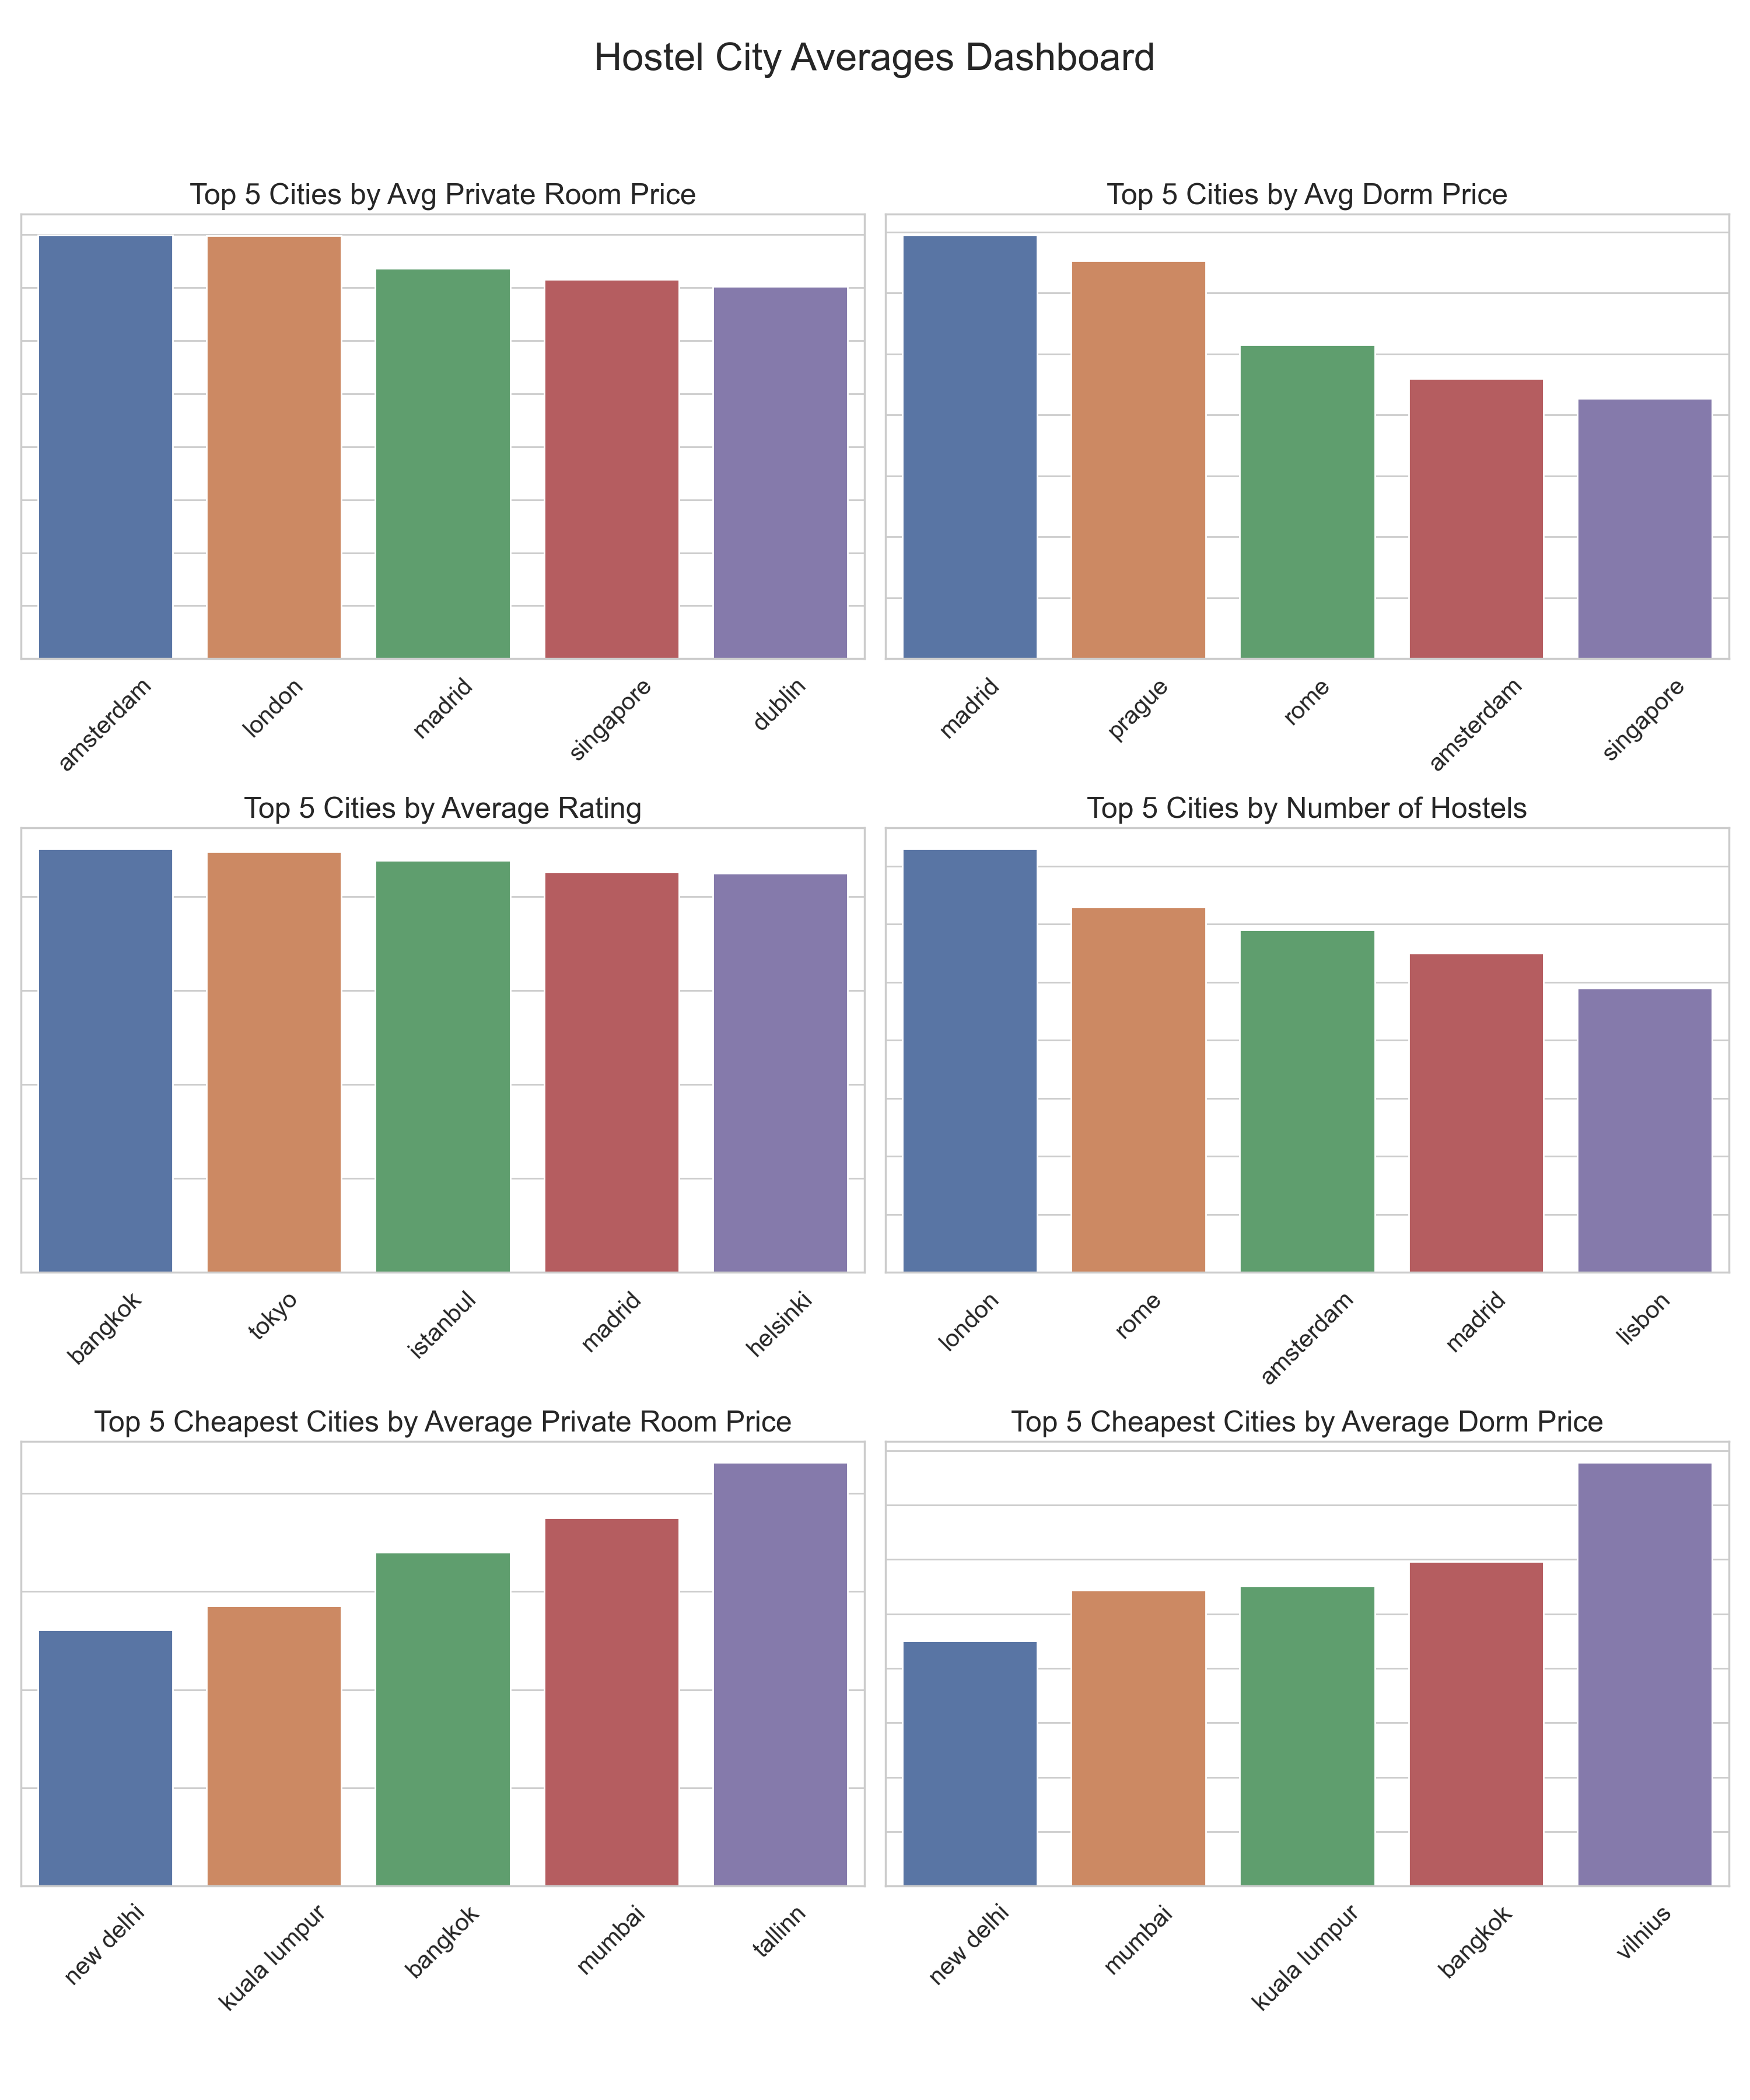

In [171]:
get_city_averages(Hostel_World_Data)

### Plotting the most reviewed hostels 
---

In [343]:
def get_hostel_averages(Hostel_World_Data):
    
    # aggregations for hostels
    hostel_name_averages = Hostel_World_Data.groupby('hostel_name').agg(
        Avg_Private_Room_Price=('private_rm_price', 'mean'),
        Avg_Dorm_Price=('dorm_price', 'mean'),
        Avg_Location_Hostel_Score=('location_hostel_score', 'mean'),
        Avg_Staff_Hostel_Score=('staff_hostel_score', 'mean'),
        Avg_Cleanliness_Hostel_Score=('cleanliness_hostel_score', 'mean'),
        Avg_Security_Hostel_Score=('security_hostel_score', 'mean'),
        Avg_Atmosphere_Hostel_Score=('atmosphere_hostel_score', 'mean'),
        Avg_Value_for_Money_Hostel_Score=('value_for_money_hostel_score', 'mean'),
        Avg_Facilities_Hostel_Score=('facilities_hostel_score', 'mean'),
        Avg_Rating=('rating', 'mean'),
        Avg_Rating_Ct=('rating_ct', 'mean'),
        Avg_Distance=('distance', 'mean'),
        Avg_Activities_City_Score=('activities_city_score', 'mean'),
        Avg_Eating_Out_City_Score=('eating_out_city_score', 'mean'),
        Avg_Shopping_City_Score=('shopping_city_score', 'mean'),
        Avg_Chilling_Out_City_Score=('chilling_out_city_score', 'mean'),
        Avg_Transport_City_Score=('transport_city_score', 'mean'),
        Avg_Sightseeing_City_Score=('sightseeing_city_score', 'mean'),
        Avg_Culture_City_Score=('culture_city_score', 'mean'),
        Avg_Nightlife_City_Score=('nightlife_city_score', 'mean'),
        Avg_Value_for_Money_City_Score=('value_for_money_city_score', 'mean')
    ).reset_index()
    
    
    top_5_hostels_by_rating_ct = hostel_name_averages.sort_values(by='Avg_Rating_Ct', ascending=False).head(5)

    # single barchart
    plt.figure(figsize=(10, 6))
    plt.bar(top_5_hostels_by_rating_ct['hostel_name'], top_5_hostels_by_rating_ct['Avg_Rating_Ct'])

    plt.title('Top 5 Hostels by Average Rating Count')
    plt.xticks(rotation=45)  # rotating the x axis
    plt.show()
    
    print(top_5_hostels_by_rating_ct[['hostel_name', 'Avg_Rating_Ct']])
    

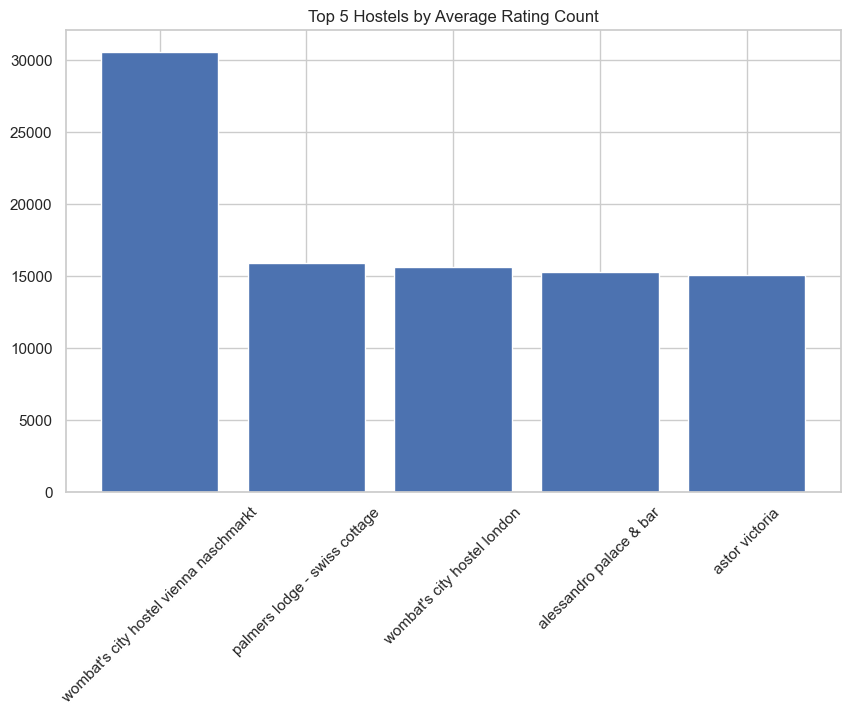

                                hostel_name  Avg_Rating_Ct
956  wombat's city hostel vienna naschmarkt        30552.0
658           palmers lodge - swiss cottage        15867.0
955             wombat's city hostel london        15654.0
45                  alessandro palace & bar        15273.0
73                           astor victoria        15076.0


In [361]:
get_hostel_averages(Hostel_World_Data)

### Plots for Aggregated Date with Dorm and Private Room Price Compared
---

In [172]:
def get_date_averages(Hostel_World_Data):
    
    date_averages = Hostel_World_Data.groupby('date').agg(
        Avg_Private_Room_Price=('private_rm_price', 'mean'),
        Avg_Dorm_Price=('dorm_price', 'mean')
    ).reset_index()
    
    
    
    
    plt.figure(figsize=(10, 6))
    plt.plot(date_averages['date'], date_averages['Avg_Private_Room_Price'], label='Avg Private Room Price')
    plt.plot(date_averages['date'], date_averages['Avg_Dorm_Price'], label='Avg Dorm Price')
    plt.title('Average Room Prices Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

    
    july_date_averages = date_averages[date_averages['date'].dt.month == 7]


    plt.figure(figsize=(10, 6))
    plt.plot(july_date_averages['date'], july_date_averages['Avg_Private_Room_Price'], label='Avg Private Room Price')
    plt.plot(july_date_averages['date'], july_date_averages['Avg_Dorm_Price'], label='Avg Dorm Price')
    plt.title('Average Hostel Prices in July, 2024')
    plt.legend()
    plt.grid(True)
    plt.show()
    

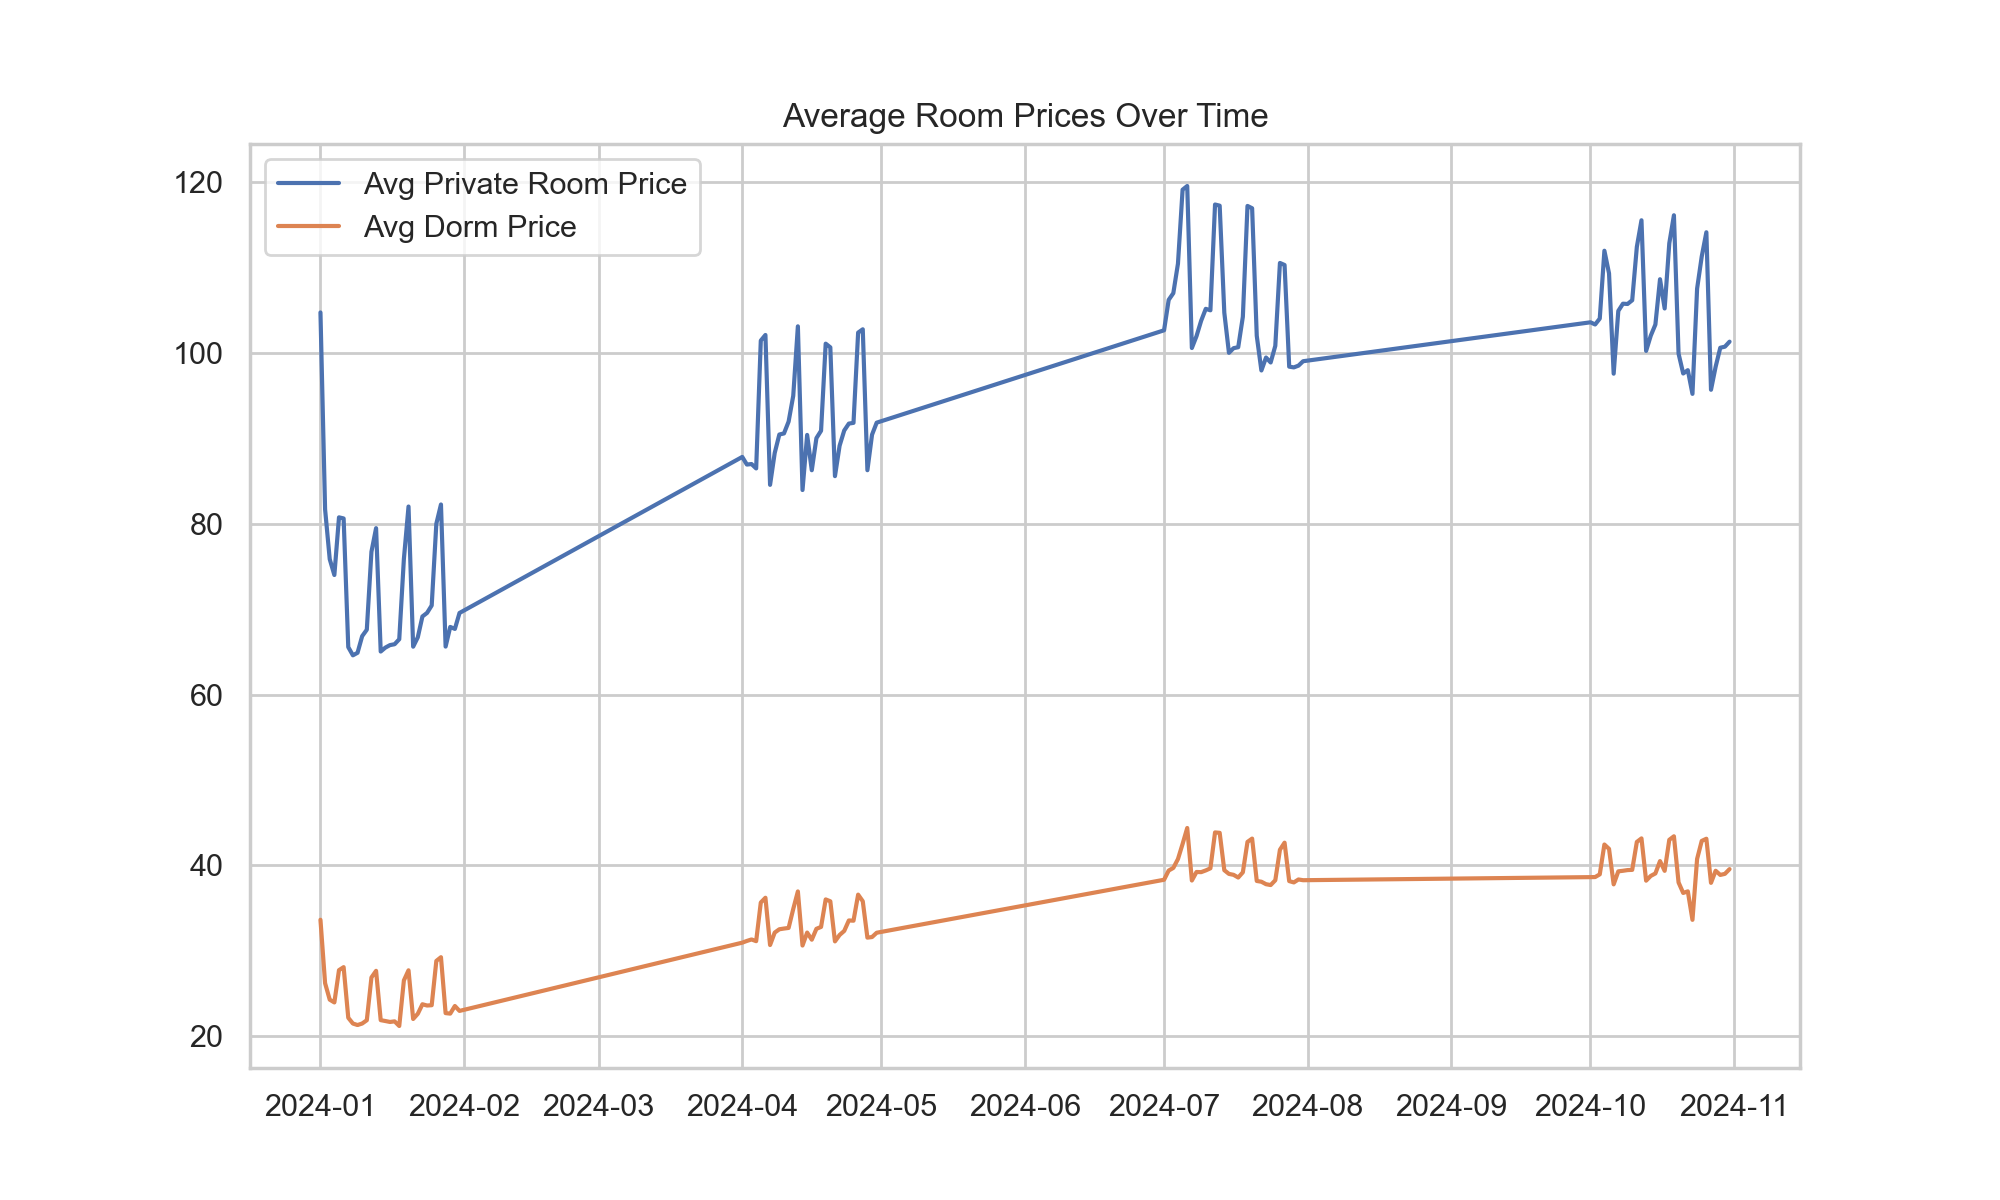

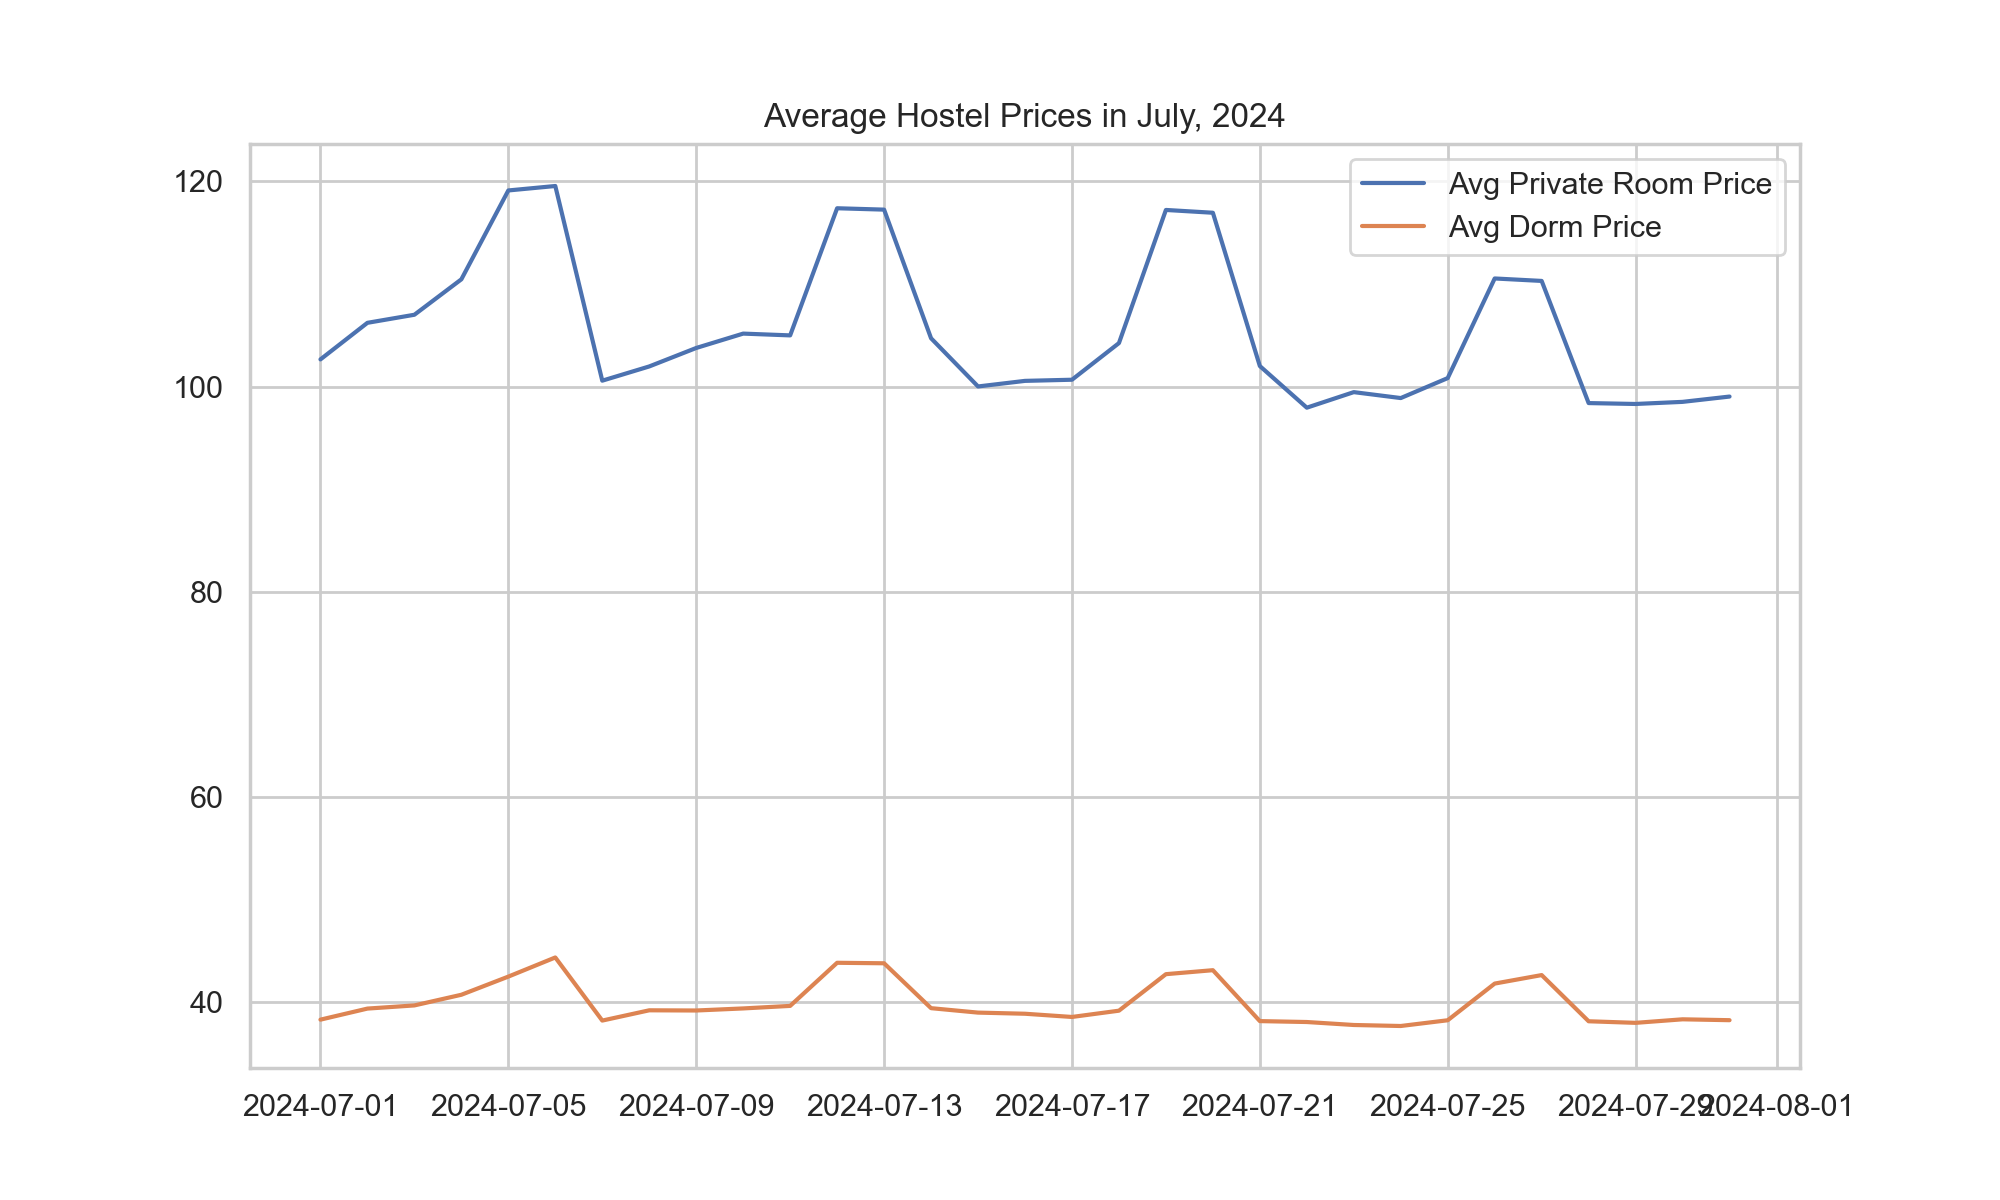

In [173]:
get_date_averages(Hostel_World_Data)

### Dashboard Creation for Top Values Time Series
---

In [174]:
def plot_top_values_time_series(Hostel_World_Data):
    
    """
    This function returns plots for various top 5 listings in the Hostel_World_Data set. 
    """
    
    sns.set(style="whitegrid")
    
    # Creating the grid of subplots
    fig, axes = plt.subplots(5, 2, figsize=(20, 40))
    fig.suptitle('Time Series Plots over Several Parameters', fontsize=20, y=0.95)
    
    
    """
    ----------------------------------------------------
    Top 5 most expensive cities by cost of private rooms
    ----------------------------------------------------
    """
    # Top 5 most expensive cities by cost of private rooms
    top_5_city_priv = ['amsterdam', 'london', 'madrid', 'singapore', 'dublin']
    top_priv = Hostel_World_Data[Hostel_World_Data['city'].isin(top_5_city_priv)]
    
    top_priv_agg = top_priv.groupby(['date', 'city']).agg(
        Avg_Private_Room_Price=('private_rm_price', 'mean')
    ).reset_index()
    
    top_priv_agg = top_priv_agg.dropna(subset=['Avg_Private_Room_Price'])
    for city in top_priv_agg['city'].unique():
        city_data = top_priv_agg[top_priv_agg['city'] == city]
        axes[0, 0].plot(city_data['date'], city_data['Avg_Private_Room_Price'], label=city)
    axes[0, 0].set_title('Top 5 Expensive Cities: Average Private Room Prices', fontsize=18)
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    axes[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axes[0, 0].xaxis.set_major_locator(mdates.MonthLocator())
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    
    
    """
    --------------------------------------------
    Top 5 most expensive cities by cost of dorms
    --------------------------------------------
    """
    # Top 5 most expensive cities by cost of dorms
    top_5_city_dorm = ['madrid', 'prague', 'rome', 'amsterdam', 'singapore']
    top_dorm = Hostel_World_Data[Hostel_World_Data['city'].isin(top_5_city_dorm)]
    
    top_dorm_agg = top_dorm.groupby(['date', 'city']).agg(
        Avg_Dorm_Price=('dorm_price', 'mean')
    ).reset_index()
    
    top_dorm_agg = top_dorm_agg.dropna(subset=['Avg_Dorm_Price'])
    for city in top_dorm_agg['city'].unique():
        city_data = top_dorm_agg[top_dorm_agg['city'] == city]    
        axes[0, 1].plot(city_data['date'], city_data['Avg_Dorm_Price'], label=city)
    axes[0, 1].set_title('Top 5 Expensive Cities: Average Dorm Prices', fontsize=18)
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    axes[0, 1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axes[0, 1].xaxis.set_major_locator(mdates.MonthLocator())
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    
    
    
    """
    --------------------------
    Top 5 highest rated cities
    --------------------------
    """
    # Top 5 highest rated cities
    top_5_city_rating = ['bangkok', 'tokyo', 'istanbul', 'madrid', 'helsinki']
    top_rated = Hostel_World_Data[Hostel_World_Data['city'].isin(top_5_city_rating)]
    
    # Priv Rooms
    top_rated_agg_priv = top_rated.groupby(['date', 'city']).agg(
        Avg_Private_Room_Price=('private_rm_price', 'mean')
    ).reset_index()
    
    top_rated_agg_priv = top_rated_agg_priv.dropna(subset=['Avg_Private_Room_Price'])
    for city in top_rated_agg_priv['city'].unique():
        city_data = top_rated_agg_priv[top_rated_agg_priv['city'] == city]
        axes[1, 0].plot(city_data['date'], city_data['Avg_Private_Room_Price'], label=city)
    axes[1, 0].set_title('Highest Rated Cities: Average Private Room Prices', fontsize=18)
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    axes[1, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axes[1, 0].xaxis.set_major_locator(mdates.MonthLocator())
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    
    # Dorm Rooms
    top_rated_agg_dorm = top_rated.groupby(['date', 'city']).agg(
        Avg_Dorm_Price=('dorm_price', 'mean')
    ).reset_index()
    
    top_rated_agg_dorm = top_rated_agg_dorm.dropna(subset=['Avg_Dorm_Price'])
    for city in top_rated_agg_dorm['city'].unique():
        city_data = top_rated_agg_dorm[top_rated_agg_dorm['city'] == city]
        axes[1, 1].plot(city_data['date'], city_data['Avg_Dorm_Price'], label=city)
    axes[1, 1].set_title('Highest Rated Cities: Average Dorm Prices', fontsize=18)
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    axes[1, 1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axes[1, 1].xaxis.set_major_locator(mdates.MonthLocator())
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    
    
    """
    ---------------------------------
    Top 5 cities by number of hostels
    ---------------------------------
    """
    # Top 5 cities by number of hostels
    top_5_city_hostel_count = ['london', 'rome', 'amsterdam', 'madrid', 'lisbon']
    top_hostel_count = Hostel_World_Data[Hostel_World_Data['city'].isin(top_5_city_hostel_count)]
    
    # Priv Rooms
    top_hostel_count_agg_priv = top_hostel_count.groupby(['date', 'city']).agg(
        Avg_Private_Room_Price=('private_rm_price', 'mean')
    ).reset_index()
    
    top_hostel_count_agg_priv = top_hostel_count_agg_priv.dropna(subset=['Avg_Private_Room_Price'])
    for city in top_hostel_count_agg_priv['city'].unique():
        city_data = top_hostel_count_agg_priv[top_hostel_count_agg_priv['city'] == city]
        axes[2, 0].plot(city_data['date'], city_data['Avg_Private_Room_Price'], label=city)
    axes[2, 0].set_title('Cities with Most Hostels: Average Private Room Prices', fontsize=18)
    axes[2, 0].legend()
    axes[2, 0].grid(True)
    axes[2, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axes[2, 0].xaxis.set_major_locator(mdates.MonthLocator())
    axes[2, 0].tick_params(axis='x', rotation=45)
    
    
    # Dorms
    top_hostel_count_agg_dorm = top_hostel_count.groupby(['date', 'city']).agg(
        Avg_Dorm_Price=('dorm_price', 'mean')
    ).reset_index()
    
    
    top_hostel_count_agg_dorm = top_hostel_count_agg_dorm.dropna(subset=['Avg_Dorm_Price'])
    
    
    for city in top_hostel_count_agg_dorm['city'].unique():
        city_data = top_hostel_count_agg_dorm[top_hostel_count_agg_dorm['city'] == city]
        axes[2, 1].plot(city_data['date'], city_data['Avg_Dorm_Price'], label=city)
    axes[2, 1].set_title('Cities with Most Hostels: Average Dorm Prices', fontsize=18)
    axes[2, 1].legend()
    axes[2, 1].grid(True)
    axes[2, 1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axes[2, 1].xaxis.set_major_locator(mdates.MonthLocator())
    axes[2, 1].tick_params(axis='x', rotation=45)
    
    
    
    
    """
    ----------------------------------------------
    Top 5 cheapest cities by cost of private rooms
    ----------------------------------------------
    """
    # Top 5 cheapest cities by cost of private rooms
    cheap_5_city_priv = ['new delhi', 'kuala lumpur', 'bangkok', 'mumbai', 'tallinn']
    cheap_priv = Hostel_World_Data[Hostel_World_Data['city'].isin(cheap_5_city_priv)]
    
    cheap_priv_agg = cheap_priv.groupby(['date', 'city']).agg(
        Avg_Private_Room_Price=('private_rm_price', 'mean')
    ).reset_index()
    
    cheap_priv_agg = cheap_priv_agg.dropna(subset=['Avg_Private_Room_Price'])
    
    for city in cheap_priv_agg['city'].unique():
        city_data = cheap_priv_agg[cheap_priv_agg['city'] == city]
        axes[3, 0].plot(city_data['date'], city_data['Avg_Private_Room_Price'], label=city)
    axes[3, 0].set_title('Cheapest Cities: Average Private Room Prices', fontsize=18)
    axes[3, 0].legend()
    axes[3, 0].grid(True)
    axes[3, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axes[3, 0].xaxis.set_major_locator(mdates.MonthLocator())
    axes[3, 0].tick_params(axis='x', rotation=45)
    
    
    
    
    """
    --------------------------------------
    Top 5 cheapest cities by cost of dorms
    --------------------------------------
    """
    # Top 5 cheapest cities by cost of dorms
    cheap_5_city_dorm = ['new delhi', 'kuala lumpur', 'bangkok', 'mumbai', 'vilnius']
    cheap_dorm = Hostel_World_Data[Hostel_World_Data['city'].isin(cheap_5_city_dorm)]
    
    cheap_dorm_agg = cheap_dorm.groupby(['date', 'city']).agg(
        Avg_Dorm_Price=('dorm_price', 'mean')
    ).reset_index()
    
    cheap_dorm_agg = cheap_dorm_agg.dropna(subset=['Avg_Dorm_Price'])
    
    for city in cheap_dorm_agg['city'].unique():
        city_data = cheap_dorm_agg[cheap_dorm_agg['city'] == city]
        axes[3, 1].plot(city_data['date'], city_data['Avg_Dorm_Price'], label=city)
    axes[3, 1].set_title('Cheapest Cities: Average Dorm Prices', fontsize=18)
    axes[3, 1].legend()
    axes[3, 1].grid(True)
    axes[3, 1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axes[3, 1].xaxis.set_major_locator(mdates.MonthLocator())
    axes[3, 1].tick_params(axis='x', rotation=45)
    
    
    
    
    """
    -------------------------------------------------------------------------
    Average private room prices for hostels with the highest count of reviews
    -------------------------------------------------------------------------
    """
    # Average private room prices for hostels with the highest count of reviews
    top_5_hostel_rating_ct = ["wombat's city hostel vienna naschmarkt", "palmers lodge - swiss cottage", 
                              "wombat's city hostel london", "alessandro palace & bar", "astor victoria"]
    pop_hostels = Hostel_World_Data[Hostel_World_Data['hostel_name'].isin(top_5_hostel_rating_ct)]
    
    
    # Priv rooms
    pop_hostels_agg_priv = pop_hostels.groupby(['date', 'hostel_name']).agg(
        Avg_Private_Room_Price=('private_rm_price', 'mean')
    ).reset_index()
    
    pop_hostels_agg_priv = pop_hostels_agg_priv.dropna(subset=['Avg_Private_Room_Price'])

    for hostel in pop_hostels_agg_priv['hostel_name'].unique():
        hostel_data = pop_hostels_agg_priv[pop_hostels_agg_priv['hostel_name'] == hostel]
        axes[4, 0].plot(hostel_data['date'], hostel_data['Avg_Private_Room_Price'], label=hostel)
    axes[4, 0].set_title('Most Reviewed Hostels: Average Private Room Prices', fontsize=18)
    axes[4, 0].legend()
    axes[4, 0].grid(True)
    axes[4, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axes[4, 0].xaxis.set_major_locator(mdates.MonthLocator())
    axes[4, 0].tick_params(axis='x', rotation=45)
    
    
    
    # Dorm rooms
    pop_hostels_agg_dorm = pop_hostels.groupby(['date', 'hostel_name']).agg(
        Avg_Dorm_Price=('dorm_price', 'mean')
    ).reset_index()
    
    pop_hostels_agg_dorm = pop_hostels_agg_dorm.dropna(subset=['Avg_Dorm_Price'])
    
    for hostel in pop_hostels_agg_dorm['hostel_name'].unique():
        hostel_data = pop_hostels_agg_dorm[pop_hostels_agg_dorm['hostel_name'] == hostel]
        axes[4, 1].plot(hostel_data['date'], hostel_data['Avg_Dorm_Price'], label=hostel)
    axes[4, 1].set_title('Most Reviewed Hostels: Average Dorm Prices', fontsize=18)
    axes[4, 1].legend()
    axes[4, 1].grid(True)
    axes[4, 1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axes[4, 1].xaxis.set_major_locator(mdates.MonthLocator())
    axes[4, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout(pad=3.0, h_pad=3.0, w_pad=2.0, rect=[0, 0.03, 1, 0.92])
    plt.subplots_adjust(top=0.92)
    plt.show()
    

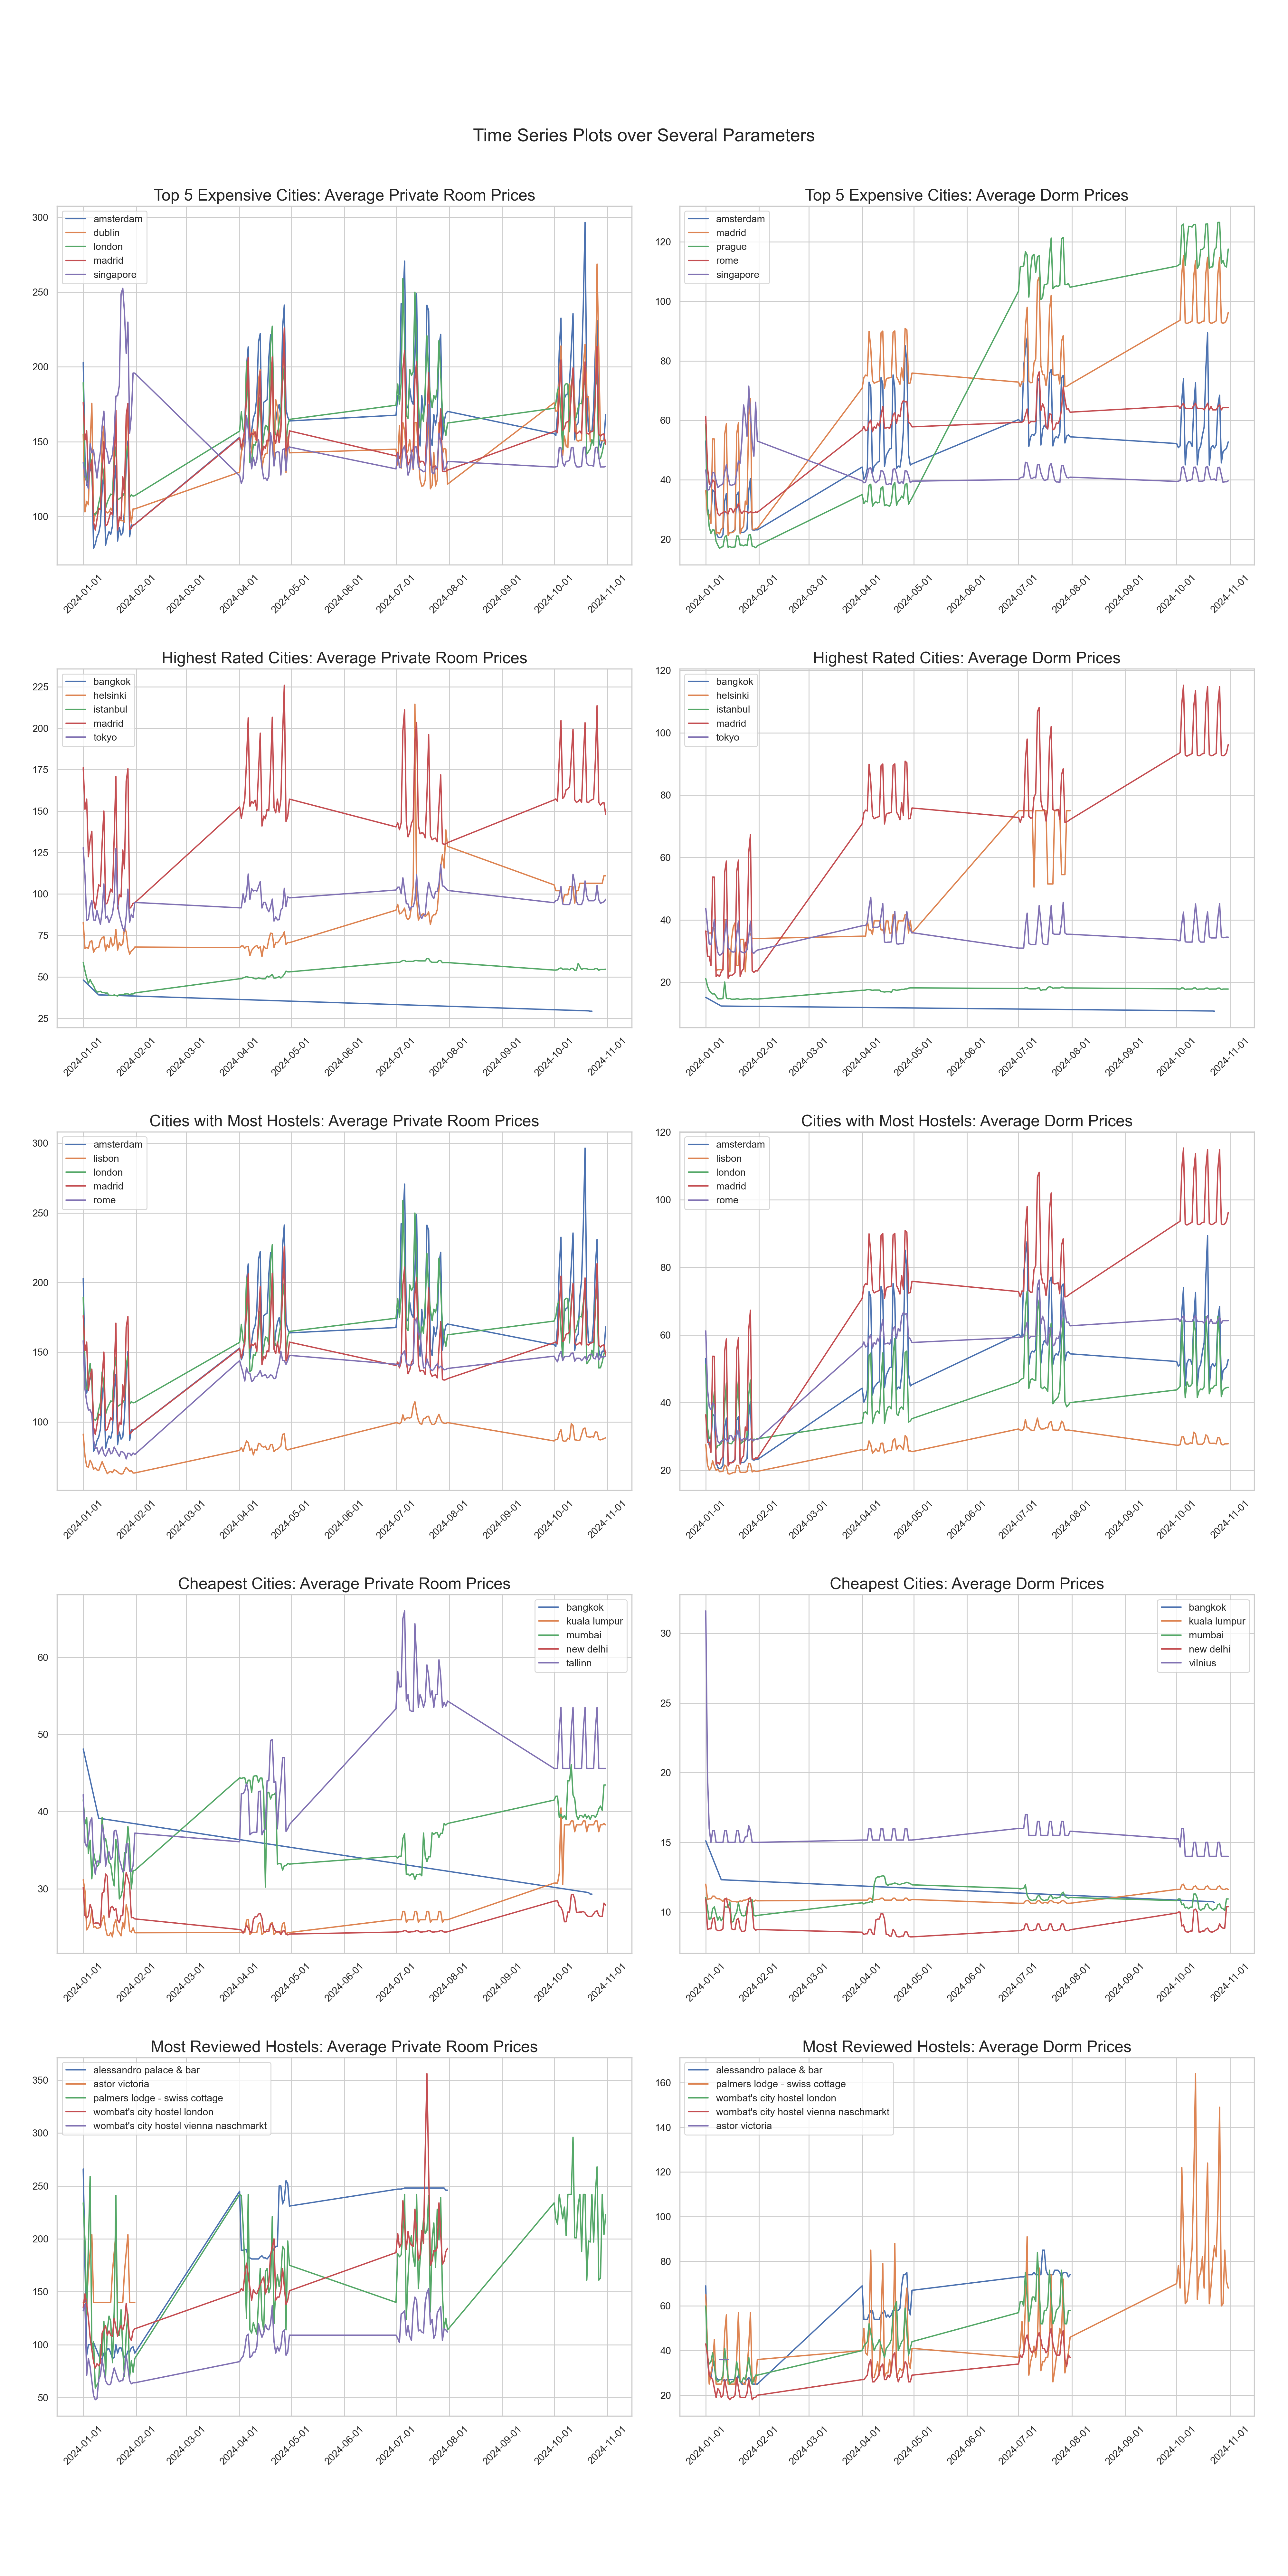

In [175]:
plot_top_values_time_series(Hostel_World_Data)

### Dashboard Creation for Top Values in July 2024
---

In [434]:
def plot_top_values_july(Hostel_World_Data):
    
    """
    This function returns plots for various top 5 listings in the Hostel_World_Data set. 
    """
    
    Hostel_World_Data = Hostel_World_Data[Hostel_World_Data['date'].dt.month == 7]
    
    sns.set(style="whitegrid")
    
    # Creating the grid of subplots
    fig, axes = plt.subplots(5, 2, figsize=(20, 40))
    fig.suptitle('July 2024 Price Data over Several Parameters', fontsize=20, y=0.95)
    
    
    """
    ----------------------------------------------------
    Top 5 most expensive cities by cost of private rooms
    ----------------------------------------------------
    """
    # Top 5 most expensive cities by cost of private rooms
    top_5_city_priv = ['amsterdam', 'london', 'madrid', 'singapore', 'dublin']
    top_priv = Hostel_World_Data[Hostel_World_Data['city'].isin(top_5_city_priv)]
    
    top_priv_agg = top_priv.groupby(['date', 'city']).agg(
        Avg_Private_Room_Price=('private_rm_price', 'mean')
    ).reset_index()
    
    top_priv_agg = top_priv_agg.dropna(subset=['Avg_Private_Room_Price'])
    for city in top_priv_agg['city'].unique():
        city_data = top_priv_agg[top_priv_agg['city'] == city]
        axes[0, 0].plot(city_data['date'], city_data['Avg_Private_Room_Price'], label=city)
    axes[0, 0].set_title('Top 5 Expensive Cities: Average Private Room Prices', fontsize=18)
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    axes[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    
    
    """
    --------------------------------------------
    Top 5 most expensive cities by cost of dorms
    --------------------------------------------
    """
    # Top 5 most expensive cities by cost of dorms
    top_5_city_dorm = ['madrid', 'prague', 'rome', 'amsterdam', 'singapore']
    top_dorm = Hostel_World_Data[Hostel_World_Data['city'].isin(top_5_city_dorm)]
    
    top_dorm_agg = top_dorm.groupby(['date', 'city']).agg(
        Avg_Dorm_Price=('dorm_price', 'mean')
    ).reset_index()
    
    top_dorm_agg = top_dorm_agg.dropna(subset=['Avg_Dorm_Price'])
    for city in top_dorm_agg['city'].unique():
        city_data = top_dorm_agg[top_dorm_agg['city'] == city]    
        axes[0, 1].plot(city_data['date'], city_data['Avg_Dorm_Price'], label=city)
    axes[0, 1].set_title('Top 5 Expensive Cities: Average Dorm Prices', fontsize=18)
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    axes[0, 1].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    
    
    
    """
    --------------------------
    Top 5 highest rated cities
    --------------------------
    """
    # Top 5 highest rated cities
    top_5_city_rating = ['bangkok', 'tokyo', 'istanbul', 'madrid', 'helsinki']
    top_rated = Hostel_World_Data[Hostel_World_Data['city'].isin(top_5_city_rating)]
    
    # Priv Rooms
    top_rated_agg_priv = top_rated.groupby(['date', 'city']).agg(
        Avg_Private_Room_Price=('private_rm_price', 'mean')
    ).reset_index()
    
    top_rated_agg_priv = top_rated_agg_priv.dropna(subset=['Avg_Private_Room_Price'])
    for city in top_rated_agg_priv['city'].unique():
        city_data = top_rated_agg_priv[top_rated_agg_priv['city'] == city]
        axes[1, 0].plot(city_data['date'], city_data['Avg_Private_Room_Price'], label=city)
    axes[1, 0].set_title('Highest Rated Cities: Average Private Room Prices', fontsize=18)
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    axes[1, 0].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    
    # Dorm Rooms
    top_rated_agg_dorm = top_rated.groupby(['date', 'city']).agg(
        Avg_Dorm_Price=('dorm_price', 'mean')
    ).reset_index()
    
    top_rated_agg_dorm = top_rated_agg_dorm.dropna(subset=['Avg_Dorm_Price'])
    for city in top_rated_agg_dorm['city'].unique():
        city_data = top_rated_agg_dorm[top_rated_agg_dorm['city'] == city]
        axes[1, 1].plot(city_data['date'], city_data['Avg_Dorm_Price'], label=city)
    axes[1, 1].set_title('Highest Rated Cities: Average Dorm Prices', fontsize=18)
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    axes[1, 1].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    
    
    """
    ---------------------------------
    Top 5 cities by number of hostels
    ---------------------------------
    """
    # Top 5 cities by number of hostels
    top_5_city_hostel_count = ['london', 'rome', 'amsterdam', 'madrid', 'lisbon']
    top_hostel_count = Hostel_World_Data[Hostel_World_Data['city'].isin(top_5_city_hostel_count)]
    
    # Priv Rooms
    top_hostel_count_agg_priv = top_hostel_count.groupby(['date', 'city']).agg(
        Avg_Private_Room_Price=('private_rm_price', 'mean')
    ).reset_index()
    
    top_hostel_count_agg_priv = top_hostel_count_agg_priv.dropna(subset=['Avg_Private_Room_Price'])
    for city in top_hostel_count_agg_priv['city'].unique():
        city_data = top_hostel_count_agg_priv[top_hostel_count_agg_priv['city'] == city]
        axes[2, 0].plot(city_data['date'], city_data['Avg_Private_Room_Price'], label=city)
    axes[2, 0].set_title('Cities with Most Hostels: Average Private Room Prices', fontsize=18)
    axes[2, 0].legend()
    axes[2, 0].grid(True)
    axes[2, 0].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    axes[2, 0].tick_params(axis='x', rotation=45)
    
    
    # Dorms
    top_hostel_count_agg_dorm = top_hostel_count.groupby(['date', 'city']).agg(
        Avg_Dorm_Price=('dorm_price', 'mean')
    ).reset_index()
    
    
    top_hostel_count_agg_dorm = top_hostel_count_agg_dorm.dropna(subset=['Avg_Dorm_Price'])
    
    
    for city in top_hostel_count_agg_dorm['city'].unique():
        city_data = top_hostel_count_agg_dorm[top_hostel_count_agg_dorm['city'] == city]
        axes[2, 1].plot(city_data['date'], city_data['Avg_Dorm_Price'], label=city)
    axes[2, 1].set_title('Cities with Most Hostels: Average Dorm Prices', fontsize=18)
    axes[2, 1].legend()
    axes[2, 1].grid(True)
    axes[2, 1].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    axes[2, 1].tick_params(axis='x', rotation=45)
    
    
    
    
    """
    ----------------------------------------------
    Top 5 cheapest cities by cost of private rooms
    ----------------------------------------------
    """
    # Top 5 cheapest cities by cost of private rooms
    cheap_5_city_priv = ['new delhi', 'kuala lumpur', 'bangkok', 'mumbai', 'tallinn']
    cheap_priv = Hostel_World_Data[Hostel_World_Data['city'].isin(cheap_5_city_priv)]
    
    cheap_priv_agg = cheap_priv.groupby(['date', 'city']).agg(
        Avg_Private_Room_Price=('private_rm_price', 'mean')
    ).reset_index()
    
    cheap_priv_agg = cheap_priv_agg.dropna(subset=['Avg_Private_Room_Price'])
    
    for city in cheap_priv_agg['city'].unique():
        city_data = cheap_priv_agg[cheap_priv_agg['city'] == city]
        axes[3, 0].plot(city_data['date'], city_data['Avg_Private_Room_Price'], label=city)
    axes[3, 0].set_title('Cheapest Cities: Average Private Room Prices', fontsize=18)
    axes[3, 0].legend()
    axes[3, 0].grid(True)
    axes[3, 0].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    axes[3, 0].tick_params(axis='x', rotation=45)
    
    
    
    
    """
    --------------------------------------
    Top 5 cheapest cities by cost of dorms
    --------------------------------------
    """
    # Top 5 cheapest cities by cost of dorms
    cheap_5_city_dorm = ['new delhi', 'kuala lumpur', 'bangkok', 'mumbai', 'vilnius']
    cheap_dorm = Hostel_World_Data[Hostel_World_Data['city'].isin(cheap_5_city_dorm)]
    
    cheap_dorm_agg = cheap_dorm.groupby(['date', 'city']).agg(
        Avg_Dorm_Price=('dorm_price', 'mean')
    ).reset_index()
    
    cheap_dorm_agg = cheap_dorm_agg.dropna(subset=['Avg_Dorm_Price'])
    
    for city in cheap_dorm_agg['city'].unique():
        city_data = cheap_dorm_agg[cheap_dorm_agg['city'] == city]
        axes[3, 1].plot(city_data['date'], city_data['Avg_Dorm_Price'], label=city)
    axes[3, 1].set_title('Cheapest Cities: Average Dorm Prices', fontsize=18)
    axes[3, 1].legend()
    axes[3, 1].grid(True)
    axes[3, 1].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    axes[3, 1].tick_params(axis='x', rotation=45)
    
    
    
    
    """
    -------------------------------------------------------------------------
    Average private room prices for hostels with the highest count of reviews
    -------------------------------------------------------------------------
    """
    # Average private room prices for hostels with the highest count of reviews
    top_5_hostel_rating_ct = ["wombat's city hostel vienna naschmarkt", "palmers lodge - swiss cottage", 
                              "wombat's city hostel london", "alessandro palace & bar", "astor victoria"]
    pop_hostels = Hostel_World_Data[Hostel_World_Data['hostel_name'].isin(top_5_hostel_rating_ct)]
    
    
    # Priv rooms
    pop_hostels_agg_priv = pop_hostels.groupby(['date', 'hostel_name']).agg(
        Avg_Private_Room_Price=('private_rm_price', 'mean')
    ).reset_index()
    
    pop_hostels_agg_priv = pop_hostels_agg_priv.dropna(subset=['Avg_Private_Room_Price'])

    for hostel in pop_hostels_agg_priv['hostel_name'].unique():
        hostel_data = pop_hostels_agg_priv[pop_hostels_agg_priv['hostel_name'] == hostel]
        axes[4, 0].plot(hostel_data['date'], hostel_data['Avg_Private_Room_Price'], label=hostel)
    axes[4, 0].set_title('Most Reviewed Hostels: Average Private Room Prices', fontsize=18)
    axes[4, 0].legend()
    axes[4, 0].grid(True)
    axes[4, 0].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    axes[4, 0].tick_params(axis='x', rotation=45)
    
    
    
    # Dorm rooms
    pop_hostels_agg_dorm = pop_hostels.groupby(['date', 'hostel_name']).agg(
        Avg_Dorm_Price=('dorm_price', 'mean')
    ).reset_index()
    
    pop_hostels_agg_dorm = pop_hostels_agg_dorm.dropna(subset=['Avg_Dorm_Price'])
    
    for hostel in pop_hostels_agg_dorm['hostel_name'].unique():
        hostel_data = pop_hostels_agg_dorm[pop_hostels_agg_dorm['hostel_name'] == hostel]
        axes[4, 1].plot(hostel_data['date'], hostel_data['Avg_Dorm_Price'], label=hostel)
    axes[4, 1].set_title('Most Reviewed Hostels: Average Dorm Prices', fontsize=18)
    axes[4, 1].legend()
    axes[4, 1].grid(True)
    axes[4, 1].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    axes[4, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout(pad=3.0, h_pad=3.0, w_pad=2.0, rect=[0, 0.03, 1, 0.92])
    plt.subplots_adjust(top=0.92)
    plt.show()

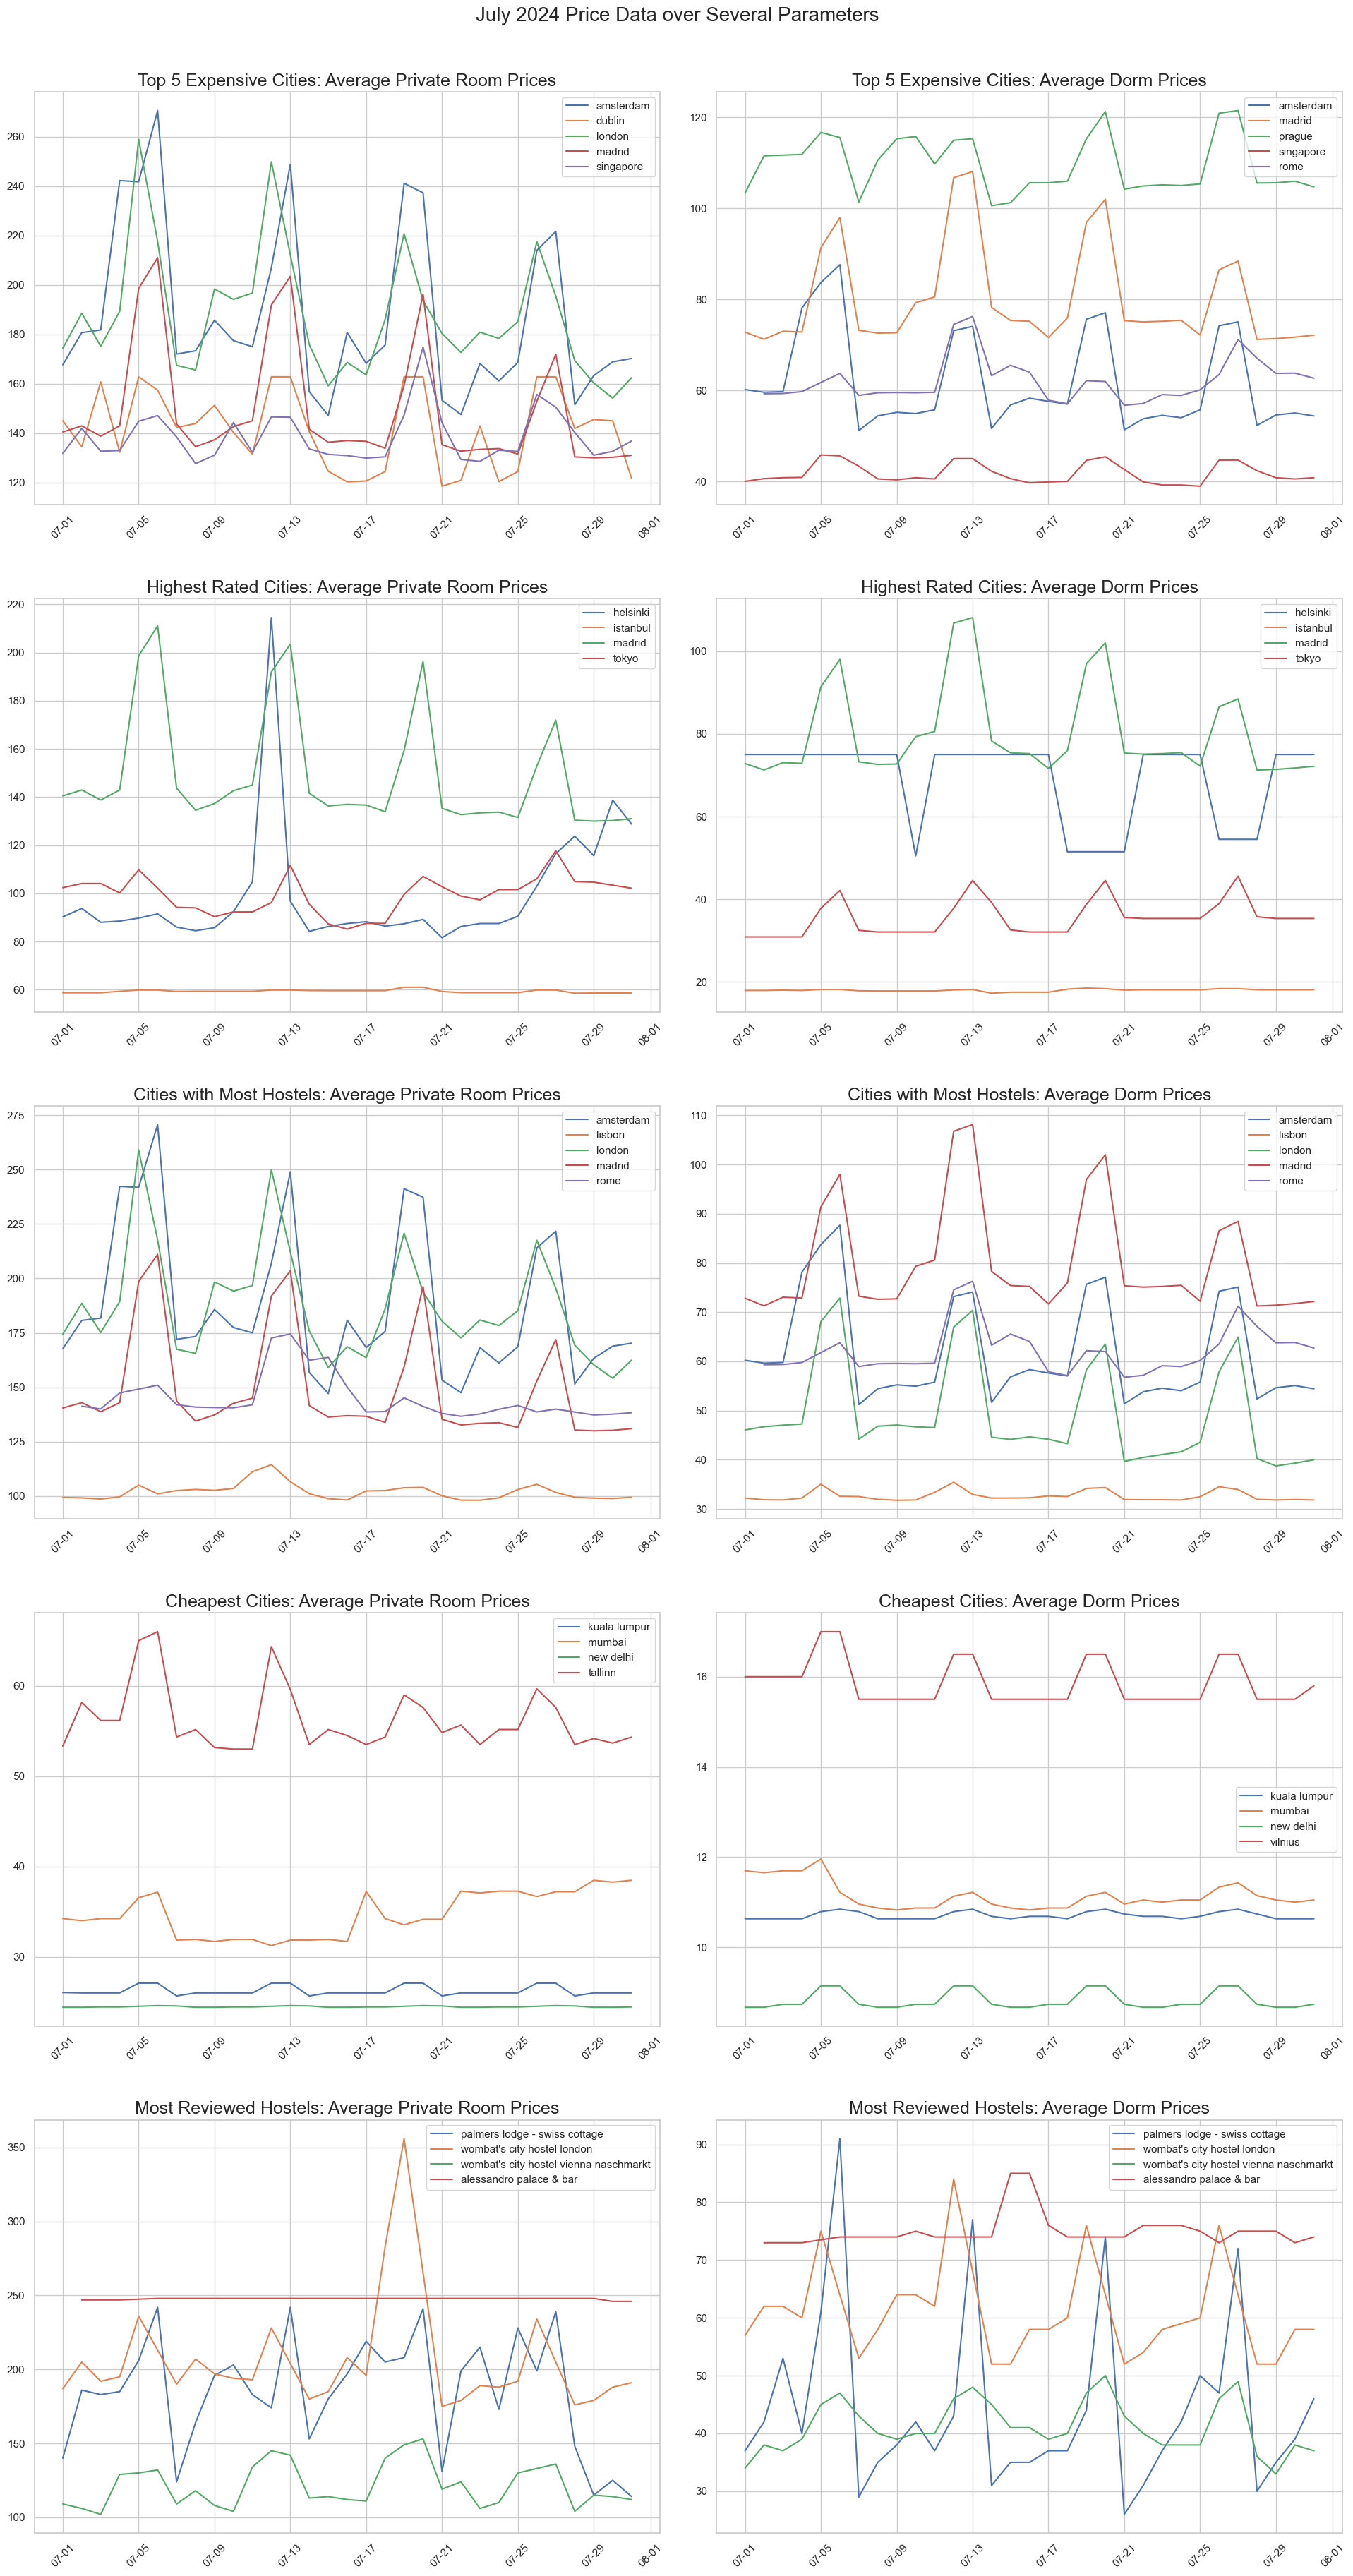

In [435]:
plot_top_values_july(Hostel_World_Data)

### Test Plots that Present the Data Very Nicely, but are not necessarily top cities
---

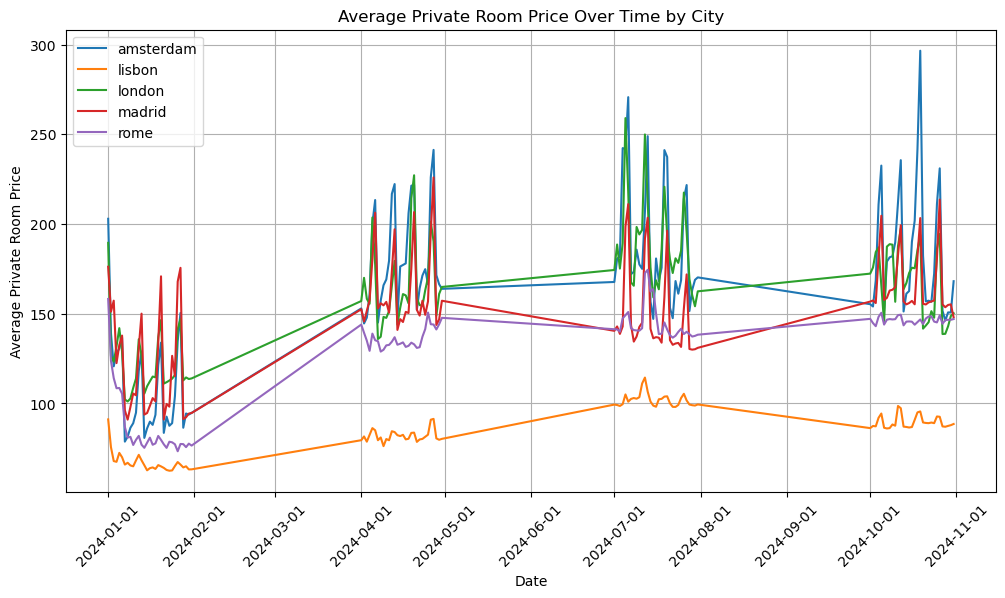

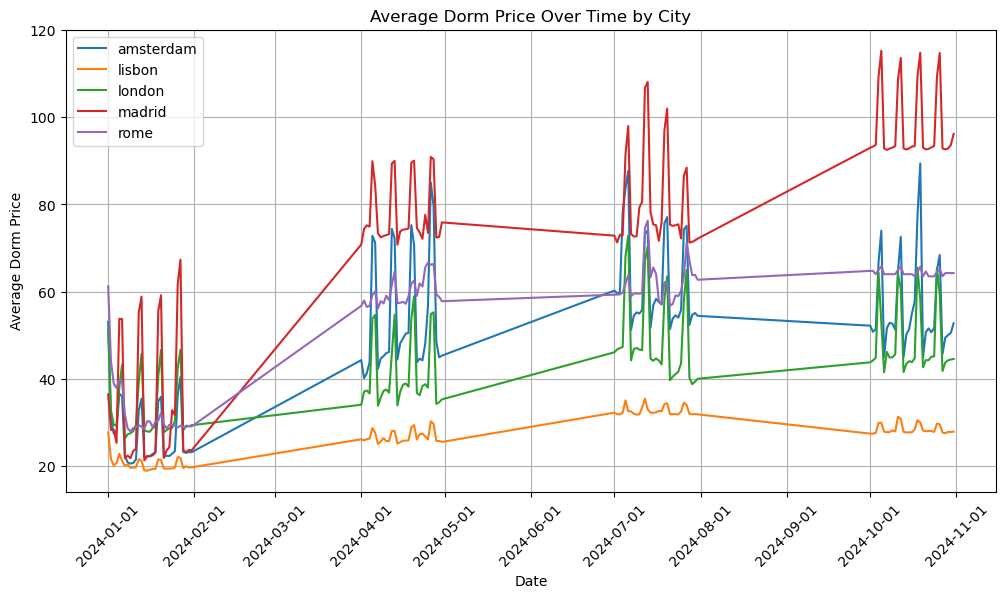

In [242]:
# plotted the line graph for Avg_Private_Room_Price
plt.figure(figsize=(12, 6))
for city in cities_date_average_top_5['city'].unique():
    city_data = cities_date_average_top_5[cities_date_average_top_5['city'] == city]
    plt.plot(city_data['date'], city_data['Avg_Private_Room_Price'], label=city)

plt.xlabel('Date')
plt.ylabel('Average Private Room Price')
plt.title('Average Private Room Price Over Time by City')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.show()

# Plotting the line graph for Avg_Dorm_Price
plt.figure(figsize=(12, 6))
for city in cities_date_average_top_5['city'].unique():
    city_data = cities_date_average_top_5[cities_date_average_top_5['city'] == city]
    plt.plot(city_data['date'], city_data['Avg_Dorm_Price'], label=city)

plt.xlabel('Date')
plt.ylabel('Average Dorm Price')
plt.title('Average Dorm Price Over Time by City')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.show()


##  Descriptive Statistics

This section will focus on the distributions of different variables across the Hostel World Data dataframe. The objective is to identify any issues in the data and handle it accordingly. 

Descriptive statistics tables will be conducted for each table in search of extreme values. Additionally, distribution hisograms will be created to gain a sense of the distributions visually. 

---

In [67]:
Hostel_World_Data.columns

Index(['hostel_name', 'rating', 'rating_ct', 'private_rm_price', 'dorm_price',
       'rating_descript', 'accomm_type', 'distance', 'city',
       'rating_descript_num', 'date', 'link', 'location_hostel_score',
       'staff_hostel_score', 'cleanliness_hostel_score',
       'security_hostel_score', 'atmosphere_hostel_score',
       'value_for_money_hostel_score', 'facilities_hostel_score', 'hostel_id',
       'continent', 'country', 'activities_city_score',
       'eating_out_city_score', 'shopping_city_score',
       'chilling_out_city_score', 'transport_city_score',
       'sightseeing_city_score', 'culture_city_score', 'nightlife_city_score',
       'value_for_money_city_score', 'ln_private_rm_price', 'ln_dorm_price',
       'combined_city_ratings', 'combined_hostel_scores'],
      dtype='object')

In [181]:
# creating the new filtered dataframe and returning some basic descriptive statistics

# adding a month column for easier filtering
Hostel_World_Data['month'] = Hostel_World_Data['date'].dt.month

# filting the data to just European hostels in July
Hostel_World_Europe = Hostel_World_Data.loc[(Hostel_World_Data["continent"] == "Europe") &
                                            (Hostel_World_Data["month"] == 7)]

# a list of variables was created because the initial output was not readable
# this allows us to look at groups of descriptive stats
groups = [
    ["rating", "rating_ct", "private_rm_price", "dorm_price", "rating_descript_num"],
    ["location_hostel_score", "staff_hostel_score", "cleanliness_hostel_score", "distance"],
    ["security_hostel_score", "atmosphere_hostel_score", "value_for_money_hostel_score"],
    ["facilities_hostel_score", "activities_city_score", "eating_out_city_score"],
    ["shopping_city_score", "chilling_out_city_score", "transport_city_score"],
    ["sightseeing_city_score", "culture_city_score", "nightlife_city_score", "value_for_money_city_score"]
]

# printing descriptive stats for each group
for group in groups:
    print(Hostel_World_Europe[group].describe(include='all').round(2))
    print("\n" + "-"*50 + "\n")

# printing out the null counts
print("\n" + "-"*50 + "\n")
print("Null Counts")
print(Hostel_World_Europe[["rating", "rating_ct", "private_rm_price", "dorm_price", "rating_descript_num", 
               "location_hostel_score", "staff_hostel_score", "cleanliness_hostel_score", "distance", 
               "security_hostel_score", "atmosphere_hostel_score", "value_for_money_hostel_score", 
               "facilities_hostel_score", "activities_city_score", "eating_out_city_score", "shopping_city_score", 
               "chilling_out_city_score", "transport_city_score", "sightseeing_city_score", "culture_city_score",
               "nightlife_city_score", "value_for_money_city_score"
              ]].isnull().sum())

print("\n" + "-"*50 + "\n")

# creating combined columns
# combining the city rating scores
combined_city_ratings = ["activities_city_score", "eating_out_city_score", "shopping_city_score",
                    "chilling_out_city_score", "transport_city_score", "sightseeing_city_score",
                     "culture_city_score", "nightlife_city_score", "value_for_money_city_score"]
Hostel_World_Europe["combined_city_ratings"] = Hostel_World_Europe[combined_city_ratings].mean(axis=1)

# combbining the hostel rating scores
combined_hostel_scores = ["location_hostel_score", "staff_hostel_score", "cleanliness_hostel_score",
                         "security_hostel_score", "atmosphere_hostel_score", "value_for_money_hostel_score",
                         "facilities_hostel_score"]
Hostel_World_Europe["combined_hostel_scores"] = Hostel_World_Europe[combined_hostel_scores].mean(axis=1)

# log transforming the prices
import numpy as np
Hostel_World_Europe['ln_private_rm_price'] = np.log(Hostel_World_Europe['private_rm_price'])
Hostel_World_Europe['ln_dorm_price'] = np.log(Hostel_World_Europe['dorm_price'])

# creating a binary variable for the weekend due to the identification of seasonality within a single month
Hostel_World_Europe['Weekend'] = Hostel_World_Europe['date'].dt.dayofweek.apply(lambda x: 1 if x >= 4 else 0) 
# >= 4 represents the weekend because of the following:
# monday 0, tuesday 1, wednesday 2, thursday 3, friday 4, saturday 5, sunday 6


         rating  rating_ct  private_rm_price  dorm_price  rating_descript_num
count  11520.00   11520.00          10441.00     8159.00             10435.00
mean       7.91    1988.14            121.61       48.25                 3.04
std        1.89    3229.38             99.56       87.28                 0.95
min        0.00       0.00             17.00        9.00                 1.00
25%        7.50     127.00             70.00       25.00                 2.00
50%        8.40     624.50            100.00       35.00                 3.00
75%        9.00    2450.00            143.00       46.00                 4.00
max       10.00   30552.00            970.00      970.00                 4.00

--------------------------------------------------

       location_hostel_score  staff_hostel_score  cleanliness_hostel_score  \
count                8892.00             8892.00                   8892.00   
mean                    8.65                8.52                      8.10   
std        

In [178]:
def descriptive_plots(Hostel_World_Europe):
    
    # creating descriptive plots 
    warnings.filterwarnings('ignore')

    # assign titles to plots
    plot_titles = [
        'Private Room Price',
        'Log of Private Room Price',
        'Dorm Price',
        'Log of Dorm Price',
        'Rating',
        'Rating Count',
        'Rating Description Number',
        'Combined Hostel Scores',
        'Combined City Ratings'
    ]

    colors = ["#0B6623", "#8A9A5B", "#01796F", "#CC5500", "#8B4000",
                     "#FFD700", "#C04000", "#5C3317", "#DAA520", "#C04000"]


    plots = [
        ggplot(Hostel_World_Europe) + aes('private_rm_price') + geom_bar(fill=colors[0]) + theme_bw() + labs(x='', y=''),
        ggplot(Hostel_World_Europe) + aes('ln_private_rm_price') + geom_bar(fill=colors[0]) + theme_bw() + labs(x='', y=''),
        ggplot(Hostel_World_Europe) + aes('dorm_price') + geom_bar(fill=colors[3]) + theme_bw() + labs(x='', y=''),
        ggplot(Hostel_World_Europe) + aes('ln_dorm_price') + geom_bar(fill=colors[3]) + theme_bw() + labs(x='', y=''),
        ggplot(Hostel_World_Europe) + aes('rating') + geom_bar(fill=colors[4]) + theme_bw() + labs(x='', y=''),
        ggplot(Hostel_World_Europe) + aes('rating_ct') + geom_bar(fill=colors[5]) + theme_bw() + labs(x='', y=''),
        ggplot(Hostel_World_Europe) + aes('rating_descript_num') + geom_bar(fill=colors[6]) + theme_bw() + labs(x='', y=''),
        ggplot(Hostel_World_Europe) + aes('combined_hostel_scores') + geom_bar(fill=colors[7]) + theme_bw() + labs(x='', y=''),
        ggplot(Hostel_World_Europe, aes(x='combined_city_ratings')) + geom_histogram(fill=colors[8]) + theme_bw() + labs(x='', y='')
    ]


    # Setting up the matplotlib figure and axes
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15)) 

    title_fontsize = 18

    # Loop over the plots and axes to save and display each plot
    # the following was created with the help of chatgpt so that we can have a nice view of all of the ggplots in one view
    for ax, plot, title in zip(axes.flatten(), plots, plot_titles):
        img_data = BytesIO()
        plot.save(img_data, format='png', verbose=False)
        img_data.seek(0)
        image = mpimg.imread(img_data)

        # Display the image in the subplot
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(title, fontsize=title_fontsize, pad=20)

    dashboard_title = "Hostel World Europe Variable Distributions by Count"
    plt.suptitle(dashboard_title, fontsize=20, fontweight='bold')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    

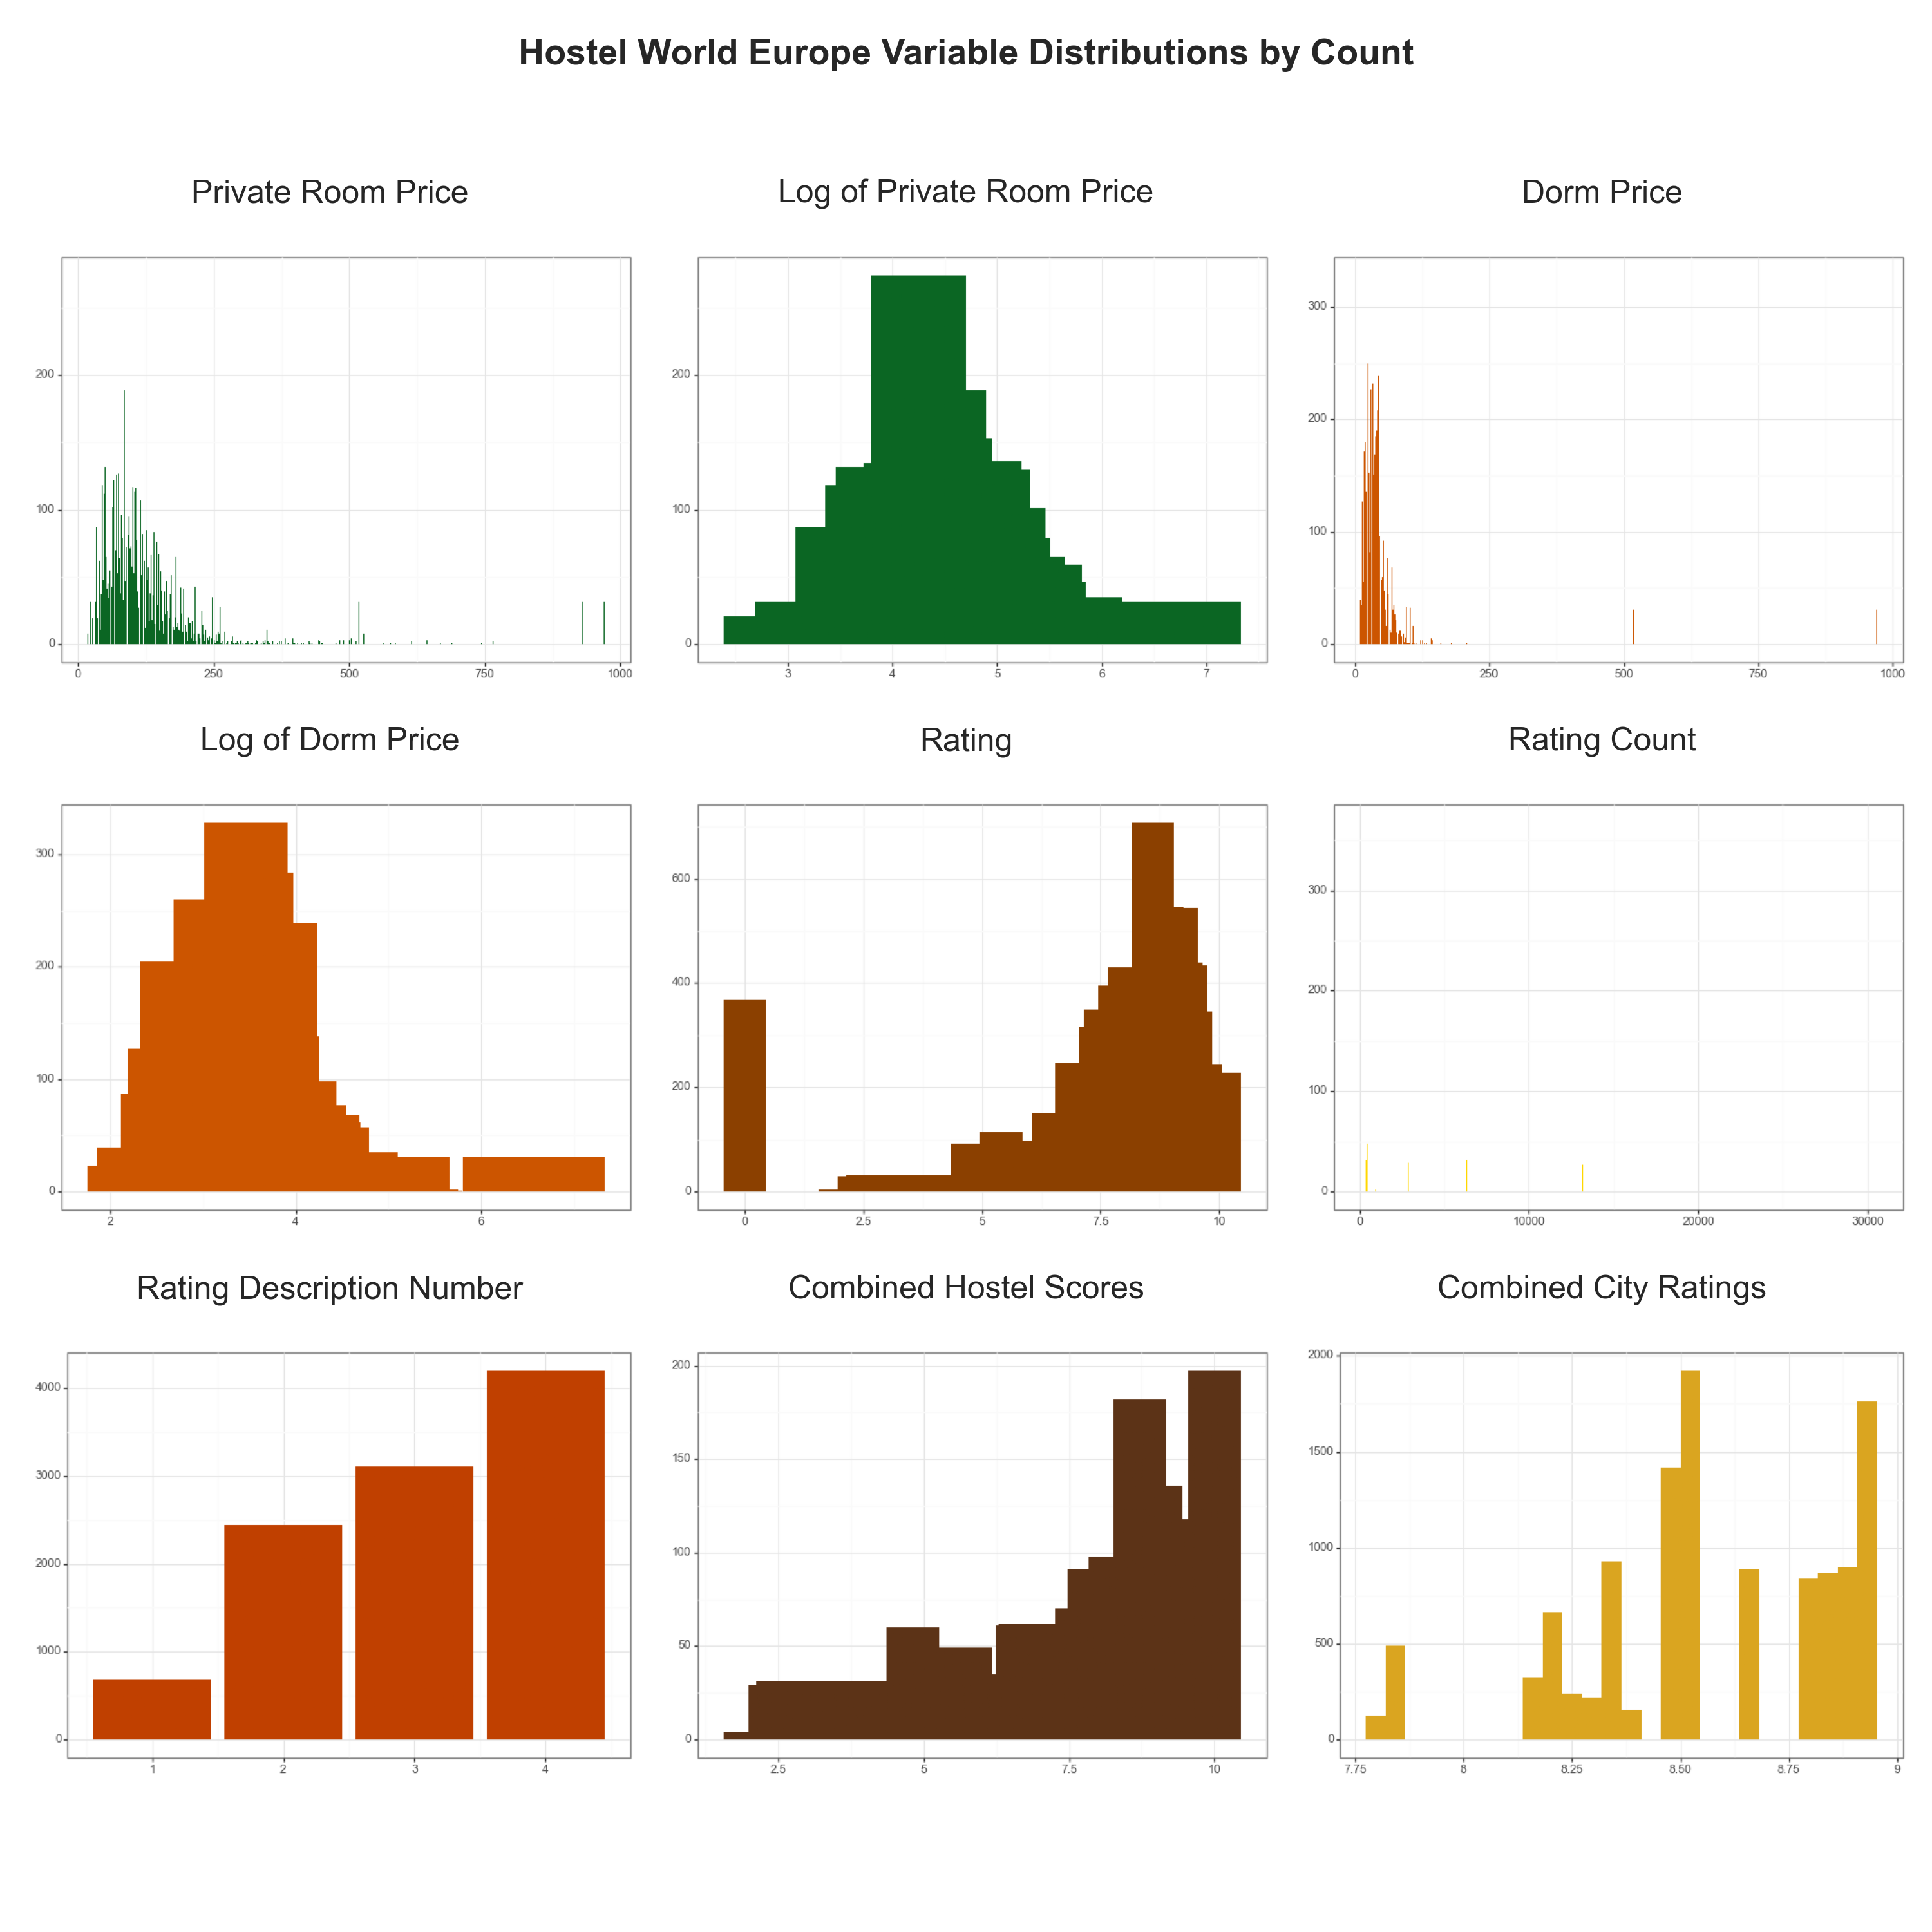

In [179]:
descriptive_plots(Hostel_World_Europe)

## Regression Analysis

This regression analysis will take a look at what variables have a potential association with the log of price room prices and the log of dorm prices in Europe, July 2024.

Two anaylsese will be conducted, one for y = `ln_private_rm_price`, and one for y = `ln_dorm_price`.

The following will be the explanatory variables for each model to see if any have an association between the prices of dorms or private rooms: 
- `Weekend`: binary variable that is 1 if the price was collected from a Friday, Saturday, or Sunday
- `rating`: the overall rating of a hostel
- `rating_descript_num`: an originally qualitative variable that ranked hostels as Good (1), Very Good (2), Fabulous (3), and Superb (4)
- `combined_hostel_scores`: merged by the mean of all individual hostel scores
- `combined_city_ratings`: merged by the mean of all individual city scores
- `distance`: distance from the city center

Private Rooms Dataframe: post cleaning Hostel_World_Priv filtered to top five cities by rating count n = 3711

Dorm Prices Dataframe: post cleaning Hostel_World_Dorm filtered to london n = 3349

---

### Analysis on the influences on log private room prices
---

In [186]:
# Analysis on `ln_private_room_price`
# First, we will create a new dataframe that drops all null values for ln_private_rm_price

# drop rows where ln_private_rm_price = null
Hostel_World_Priv = Hostel_World_Europe.dropna(subset=['ln_private_rm_price'])
Hostel_World_Priv = Hostel_World_Priv.loc[Hostel_World_Priv["city"].isin(["london", "amsterdam", "lisbon", "madrid", "rome"])]


In [187]:
Hostel_World_Priv

hostel_name  rating  rating_ct  \
5167                       alessandro palace & bar     8.4    15273.0   
5168                                generator rome     8.3     1714.0   
5169                         palladini hostel rome     8.0     5773.0   
5170                             freedom traveller     7.6     7950.0   
5171                             funny palace rome     7.8     3272.0   
...                                            ...     ...        ...   
39248  hi parque das nações – pousada de juventude     7.7      268.0   
39249                    alface bairro alto hostel     6.6      939.0   
39250                             vistas de lisboa     7.9      367.0   
39251                               lisbon calling     9.2      517.0   
39252                                    saturdays     NaN        NaN   

       private_rm_price  dorm_price rating_descript        accomm_type  \
5167              247.0        73.0        Fabulous             Hostel   
5168              152.0        68.0        Fabulous             Hostel   
5169              213.0        70.0        Fabulous             Hostel   
5170               90.0        43.0       Very Good             Hostel   
5171              173.0        77.0       Very Good             Hostel   
...                 ...         ...             ...                ...   
39248              63.0        26.0       Very Good             Hostel   
39249              70.0         NaN            Good             Hostel   
39250             140.0        46.0       Very Good             Hostel   
39251              94.0         NaN          Superb             Hostel   
39252              80.0         NaN             NaN  Bed and Breakfast   

       distance    city  rating_descript_num  ... sightseeing_city_score  \
5167        1.8    rome                  4.0  ...                    9.6   
5168        1.9    rome                  4.0  ...                    9.6   
5169        1.5    rome                  4.0  ...                    9.6   
5170        1.5    rome                  2.0  ...                    9.6   
5171        1.9    rome                  2.0  ...                    9.6   
...         ...     ...                  ...  ...                    ...   
39248       8.0  lisbon                  2.0  ...                    9.2   
39249       0.4  lisbon                  1.0  ...                    9.2   
39250       0.2  lisbon                  2.0  ...                    9.2   
39251       0.8  lisbon                  3.0  ...                    9.2   
39252       1.2  lisbon                  NaN  ...                    9.2   

      culture_city_score  nightlife_city_score  value_for_money_city_score  \
5167                 9.6                   7.7                         7.7   
5168                 9.6                   7.7                         7.7   
5169                 9.6                   7.7                         7.7   
5170                 9.6                   7.7                         7.7   
5171                 9.6                   7.7                         7.7   
...                  ...                   ...                         ...   
39248                9.2                   8.6                         8.9   
39249                9.2                   8.6                         8.9   
39250                9.2                   8.6                         8.9   
39251                9.2                   8.6                         8.9   
39252                9.2                   8.6                         8.9   

       month  combined_city_ratings  combined_hostel_scores  \
5167       7               8.511111                     NaN   
5168       7               8.511111                8.285714   
5169       7               8.511111                8.057143   
5170       7               8.511111                7.600000   
5171       7               8.511111                7.800000   
...      ...                    ...          

### Regression analysis on log private room prices
---

In [188]:
# regression analysis on ln_private_rm_price
reg1 = smf.ols(formula="ln_private_rm_price~rating", data=Hostel_World_Priv).fit(cov_type="HC1")
reg2 = smf.ols(formula="ln_private_rm_price~rating+rating_descript_num", data=Hostel_World_Priv).fit(cov_type="HC1")
reg3 = smf.ols(formula="ln_private_rm_price~rating+rating_descript_num+combined_hostel_scores", data=Hostel_World_Priv).fit(cov_type="HC1")
reg4 = smf.ols(formula="ln_private_rm_price~rating+rating_descript_num+combined_hostel_scores+combined_city_ratings", data=Hostel_World_Priv).fit(cov_type="HC1")
reg5 = smf.ols(formula="ln_private_rm_price~rating+rating_descript_num+combined_hostel_scores+combined_city_ratings+distance", data=Hostel_World_Priv).fit(cov_type="HC1")
reg6 = smf.ols(formula="ln_private_rm_price~rating+rating_descript_num+combined_hostel_scores+combined_city_ratings+distance+Weekend", data=Hostel_World_Priv).fit(cov_type="HC1")

stargazer = Stargazer([reg1, reg2, reg3, reg4, reg5, reg6])
stargazer.covariate_order(["rating", "rating_descript_num", "combined_hostel_scores", "combined_city_ratings", "distance", "Weekend", "Intercept"])
stargazer.rename_covariates({"ln_private_rm_price":"Log Price Private Room", "rating":"Rating", "rating_descript_num":"Rating Descriptor", "combined_hostel_scores":"Hostel Amenities Score", "combined_city_ratings":"City Amenities Score", "distance":"Distance from Center", "Weekend":"Weekend", "Intercept":"Constant"})
stargazer


**Interpretation**

To keeps things more simple, we will refer to the interaction table and identify correaltions here. 
- Ratings were found to have a statistically significant negative correlatiion with log prices of private rooms. This could be related to customers will rate a hostel higher when they pay lass for this hostel. 
- Hostel Amenities Score was found to have a statistically significant positive correatlion with log prices of private rooms. The higher the aggregated hostel amenities scores tends to be associated with higher prices. This may be due to the fact that the more a hostel puts into the actual hostel itself, the more expensive the cost will be.
- City Amenities Score were found to have a statistically significant negative correatlion with log prices of private rooms. This could be related to the fact that individuals enjoy a city more when they paid less for their hostel, since they feel more comfortable spending money on activities in the city. 
- Weekends were found to have a statistically significant positive correlation with log prices of private rooms. This could be related to partying on the weekends, or a higher demand in rooms on the weekends. 


In [190]:
reg7 = smf.ols(formula="ln_private_rm_price~Weekend", data=Hostel_World_Priv.query("Weekend==1")).fit(cov_type="HC1")
reg8 = smf.ols(formula="ln_private_rm_price~Weekend", data=Hostel_World_Priv.query("Weekend==0")).fit(cov_type="HC1")
reg9 = smf.ols(formula="ln_private_rm_price~Weekend+rating_descript_num*Weekend", data=Hostel_World_Priv).fit(cov_type="HC1")

stargazer = Stargazer([reg7, reg8, reg9])
stargazer.rename_covariates({"ln_private_rm_price":"Log Price Private Room", "rating_descript_num":"Rating Descriptor", "rating_descript_num:Weekend":"Rating Descriptor|Weekend Interaction", "Intercept":"Constant"})
stargazer.custom_columns(["Weekend", "Weekday", "All Interaction"], [1, 1, 1])
stargazer


**Interpretation**

Let's take a closer look at the weekends and weekdays. This regression table looks at them individually, and then incorporates the rating descriptor. 

- Unconditionally, weekend private room prices are higher than weekday private room prices. This is statistically significant at the 1% threshold. This suggests that there is a significant in prices over the weekends compared to weekdays. 
- Rating Descriptors were found to have a statistically significant positive correlation on weekday private room prices. When interacted with weekends, these descriptors no longer have any correlation with prices. This would imply that there is a positive association between prices and rating desciptors. 


### Regression analysis on log dorm prices
---

In [192]:
# Analysis on `ln_dorm_price`
# First, we will create a new dataframe that drops all null values for ln_dorm_price

# drop rows where ln_private_rm_price = null
Hostel_World_Dorm = Hostel_World_Europe.dropna(subset=['ln_dorm_price'])
Hostel_World_Dorm = Hostel_World_Dorm.loc[Hostel_World_Dorm["city"].isin(["london", "amsterdam", "lisbon", "madrid", "rome"])]


In [193]:
# regression on dorm prices
reg10 = smf.ols(formula="ln_dorm_price~rating", data=Hostel_World_Dorm).fit(cov_type="HC1")
reg11 = smf.ols(formula="ln_dorm_price~rating+rating_descript_num", data=Hostel_World_Dorm).fit(cov_type="HC1")
reg12 = smf.ols(formula="ln_dorm_price~rating+rating_descript_num+combined_hostel_scores", data=Hostel_World_Dorm).fit(cov_type="HC1")
reg13 = smf.ols(formula="ln_dorm_price~rating+rating_descript_num+combined_hostel_scores+combined_city_ratings", data=Hostel_World_Dorm).fit(cov_type="HC1")
reg14 = smf.ols(formula="ln_dorm_price~rating+rating_descript_num+combined_hostel_scores+combined_city_ratings+distance", data=Hostel_World_Dorm).fit(cov_type="HC1")
reg15 = smf.ols(formula="ln_dorm_price~rating+rating_descript_num+combined_hostel_scores+combined_city_ratings+distance+Weekend", data=Hostel_World_Dorm).fit(cov_type="HC1")

stargazer = Stargazer([reg10, reg11, reg12, reg13, reg14, reg15])
stargazer.covariate_order(["rating", "rating_descript_num", "combined_hostel_scores", "combined_city_ratings", "distance", "Weekend", "Intercept"])
stargazer.rename_covariates({"ln_dorm_price":"Log Dorm Room", "rating":"Rating", "rating_descript_num":"Rating Descriptor", "combined_hostel_scores":"Hostel Amenities Score", "combined_city_ratings":"City Amenities Score", "distance":"Distance from Center", "Weekend":"Weekend", "Intercept":"Constant"})
stargazer


**Interpretation for Dorm Prices**

To keeps things more simple, we will refer to the interaction table and identify correaltions here. 

- Ratings were found to have a statistically significant negative correlatiion with log prices of dorms. This could be related to customers will rate a hostel higher when they pay lass for this hostel. 
- Rating Descriptor (Good, Very Good, Fabulous, Superb) was found to have a statistically significant negative correatlion with log prices of private rooms. This could be due to the same reason as the ratings variable. 
- Hostel Amenities Score was found to have a statistically significant positive correatlion with log prices of dorm room prices. The higher the aggregated hostel amenities scores tends to be associated with higher prices. This may be due to the fact that the more a hostel puts into the actual hostel itself, the more expensive the cost will be.
- City Amenities Score were found to have a statistically significant negative correatlion with log prices of dorms. This could be related to the fact that individuals enjoy a city more when they paid less for their hostel, since they feel more comfortable spending money on activities in the city.  
- Distance was found to have a statistically significant negative correlation with log dorm prices. This could be associated to the fact that the close a hostel is to the center, the more expensive it will be due to demand. 
- Weekends were found to have a statistically significant positive correlation with log prices of dorm rooms. This could be because of partying on the weekends. 

In [194]:
reg16 = smf.ols(formula="ln_dorm_price~Weekend", data=Hostel_World_Dorm.query("Weekend==1")).fit(cov_type="HC1")
reg17 = smf.ols(formula="ln_dorm_price~Weekend", data=Hostel_World_Dorm.query("Weekend==0")).fit(cov_type="HC1")
reg18 = smf.ols(formula="ln_dorm_price~Weekend+rating_descript_num*Weekend", data=Hostel_World_Dorm).fit(cov_type="HC1")

stargazer = Stargazer([reg16, reg17, reg18])
stargazer.rename_covariates({"ln_dorm_price":"Log Dorm Room", "rating_descript_num":"Rating Descriptor", "rating_descript_num:Weekend":"Rating Descriptor|Weekend Interaction", "Intercept":"Constant"})
stargazer.custom_columns(["Weekend", "Weekday", "All Interaction"], [1, 1, 1])
stargazer

**Interpretation**

Let's take a closer look at the weekends and weekdays. This regression table looks at them individually, and then incorporates the rating descriptor. 

- Unconditionally, weekend private room prices are higher than weekday private room prices. This is statistically significant at the 1% threshold. There is a clear differenation between prices on the weekends and the weekdays, where weekends are significantly more expensive than weekdays. 


### Conclusion
---

When it comes to hostel prices, private rooms and dorm rooms seem to be associated with similar factors. One exception to this was that dorm prices were associated by changes in distance, while private room prices were not. This could be related to the fact that people who seek private rooms may not be as socialable, and may not want to be near the city center as much, so prices for private rooms are not impacted by distance, whereas with dorms, there is a chance that hostels have found that people renting dorm spaces are more likely to pay more to be closer to the city center. 

Weekdays were found to consistently have statistically significant higher prices as compared to weekdays. This could be tied to individuals who use Hostel World want to party on the weekends, and are willing to pay more money for a weekend hostel. 

City Amenities Scores, which include rating scales for how guests feel about a city and the different aspects that city has to offer (such as shopping, eating out, activities, etc.) was consistently found to be significantly negatively correlated to Hostel World prices. This could be due to the fact that when individuals pay less for their accommodation, they have a greater sentiment for the city because they have more spending capabilities. 

Hostels Amenitiy Scores had a consistently significant positive correlation, suggesting that higher quality hostels are more expensive. However, the overall rating score for the hostel was actually founf to have a significant negative correlation, suggesting that individual will rate a hostel higher when they pay less for this hostel. 